In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import copy
import os

import sys
import time
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.mlab as mlab
from helper import df_to_latex, fig_path, set_figsize, tab_path

# Import code from src
sys.path.insert(0, '../src/')
import vmc 


# Set plot style
sns.set(context="paper", style='darkgrid', rc={"axes.facecolor": "0.96"})

fontsize = "large"

params = {"font.family": "serif",
          "font.sans-serif": ["Computer Modern"],
          "axes.labelsize": fontsize,
          "legend.fontsize": fontsize,
          "xtick.labelsize": fontsize,
          "ytick.labelsize": fontsize,
          "legend.handlelength": 2
          }


plt.rcParams.update(params)
plt.rc('text', usetex=True)

"""
# Set plot style
sns.set(context="paper", style='darkgrid', rc={"axes.facecolor": "0.96"})

# Set fontsizes in figures
fontsize = 10
tex_fonts = {
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern"],
    "axes.labelsize": fontsize,
    "font.size": fontsize,
    "legend.fontsize": fontsize,
    "xtick.labelsize": fontsize-1,
    "ytick.labelsize": fontsize-1,
    'legend.handlelength': 2
}

plt.rcParams.update(tex_fonts)
"""
# Set figure size
width = 410 #360
figsize = set_figsize(width, fraction=1)

In [2]:
def exact_energy(N, dim, omega):
    return (omega * dim * N) / 2

def safe_initial_positions_no_interactions(wavefunction, alpha, N, dim, seed=None):
    rng = np.random.default_rng(seed=seed)
    positions = rng.random(size=(N, dim))

    # safe initialization
    wf2 = wavefunction.pdf(positions, alpha)
    while np.sum(wf2) <= 1e-14:
        positions *= 0.5
        wf2 = wavefunction.pdf(positions, alpha)

    return positions

def safe_initial_positions_w_interactions(wavefunction, alpha, N, dim, seed=None): 
    rng = np.random.default_rng(seed=seed)
    positions = rng.random(size=(N, dim))
    
    # safe initialization
    wf2 = wavefunction.pdf(positions, alpha)
    while np.sum(wf2) <= 1e-14: 
        positions *= 2.0
        wf2 = wavefunction.pdf(positions, alpha)
        
    return positions

def interact_initial_positions(wf, alpha, N, dim, a=0.00433):

    rng = np.random.default_rng()

    def corr_factor(r1, r2):
        rij = np.linalg.norm(r1 - r2)
        if rij <= a:
            return 0.
        else:
            return 1 - (a / rij)

    scale = 2.
    r = np.random.randn(N, dim) * scale
    #r = rng.random(size=(N, dim))

    rerun = True
    while rerun:
        rerun = False
        for i in range(N):
            for j in range(i + 1, N):
                corr = corr_factor(r[i, :], r[j, :])
                if corr == 0.:
                    print("corr=0 encountered")
                    rerun = True
                    r[i, :] = np.random.randn() * scale
                    r[j, :] = np.random.randn() * scale
        scale *= 1.5

    return r, scale

def get_mean_w_standard_error_grid_search(data, alphas): 
    data_dict = {"alpha": alphas, "mean_energy": [], "standard_error_of_the_mean": []}
    for i, alpha in enumerate(alphas): 
        energies_alpha = data["energy"][data["alpha"]==alpha]
        standard_errors_alpha = data["standard_error"][data["alpha"]==alpha]
        mean_energy_alpha = np.mean(energies_alpha)
        standard_error_of_the_mean = np.std(standard_errors_alpha)/np.sqrt(len(standard_errors_alpha))
        data_dict["mean_energy"].append(mean_energy_alpha)
        data_dict["standard_error_of_the_mean"].append(standard_error_of_the_mean)
        
    dataframe = pd.DataFrame(data=data_dict)
    return dataframe

In [3]:
def one_body_density(positions, range_of_x): 
    dx = range_of_x[1]-range_of_x[0]
    dy = dx
    densities = np.zeros((len(range_of_x), len(range_of_x)))
    min_x = range_of_x[0]
    min_y = min_x
    for x, y in positions: 
        try: 
            densities[int((x-min_x)//dx), int((y-min_y)//dy)] += 1
        except: 
            pass
        
    return densities

def one_body_density_1D(positions, range_of_x): 
    dx = range_of_x[1]-range_of_x[0]
    densities = np.zeros(len(range_of_x))
    min_x = range_of_x[0]
    for x in positions: 
        try: 
            densities[int((x-min_x)//dx)] += 1
        except: 
            pass
        
    return densities

def oneBodyDensity(pos, bins, mode="radial"):

    if mode == "radial":
        density = np.zeros(bins.shape[0])
        r_min = bins[0]
        dr = bins[1] - bins[0]
        rPos = np.linalg.norm(pos, axis=1)
        for r in rPos:
            try:
                density[int((r - r_min) // dr)] += 1
            except:
                pass

        return density / dr*pos.shape[0]

    if mode == "1D":
        density = np.zeros(bins.shape[0])
        x_min = bins[0]
        dx = bins[1] - bins[0]
        for x in pos:
            try:
                density[int((x - x_min) // dx)] += 1
            except:
                pass

        return density / dx

        return density / pos.shape[0]

# Histogram plots of distance 
## Comparison N=100

In [58]:
N = 100      # Number of particles
dim = 2      # Dimensionality
omega = 1.   # Oscillator frequency

# Exact energy 
exact_E = exact_energy(N, dim, omega)

# Instantiate wave function
wf = vmc.ASHONIB(N, dim, omega)

# Instantiate sampler
sampler = vmc.samplers.OBDMetropolis(wf)

# Config
nsamples = int(2**18)
initial_alpha = 0.5
initial_positions = safe_initial_positions_no_interactions(wf, initial_alpha, N, dim)
start = time.time()
final_state, positions_array_NI_100 = sampler.sample(nsamples,
                                                 initial_positions,
                                                 initial_alpha,
                                                 scale=1.0,  # METROPOLIS
                                                 #dt=1e-10,     # METROPOLIS-HASTINGS
                                                 nchains=1,
                                                 warm=True,
                                                 warmup_iter=20000,
                                                 tune=True,
                                                 tune_iter=10000,
                                                 tune_interval=500,
                                                 )

end = time.time()
print("Sampler elapsed time:", end - start)




wf = vmc.ASHOIB(N, dim, omega)
sampler = vmc.samplers.OBDMetropolis(wf)
initial_positions, scale = interact_initial_positions(wf, initial_alpha, N, dim)
start = time.time()
final_state, positions_array_I_100 = sampler.sample(nsamples,
                                                initial_positions, 
                                                initial_alpha, 
                                                scale=1.0, 
                                                nchains=1, 
                                                warm=True, 
                                                warmup_iter=50000, 
                                                tune=True,
                                                tune_iter=10000,
                                                tune_interval=500,
                                                )
end = time.time()
print("Sampler elapsed time:", end - start)

Acceptance rate=0.542205810546875
Avg radial distance=0.8666110362122624
Sampler elapsed time: 28.59962248802185
Acceptance rate=0.3985328674316406
Avg radial distance=1.002595449487708
Sampler elapsed time: 380.8054747581482


Average NI: 0.800994009214684
Average I: 0.9453773228541468


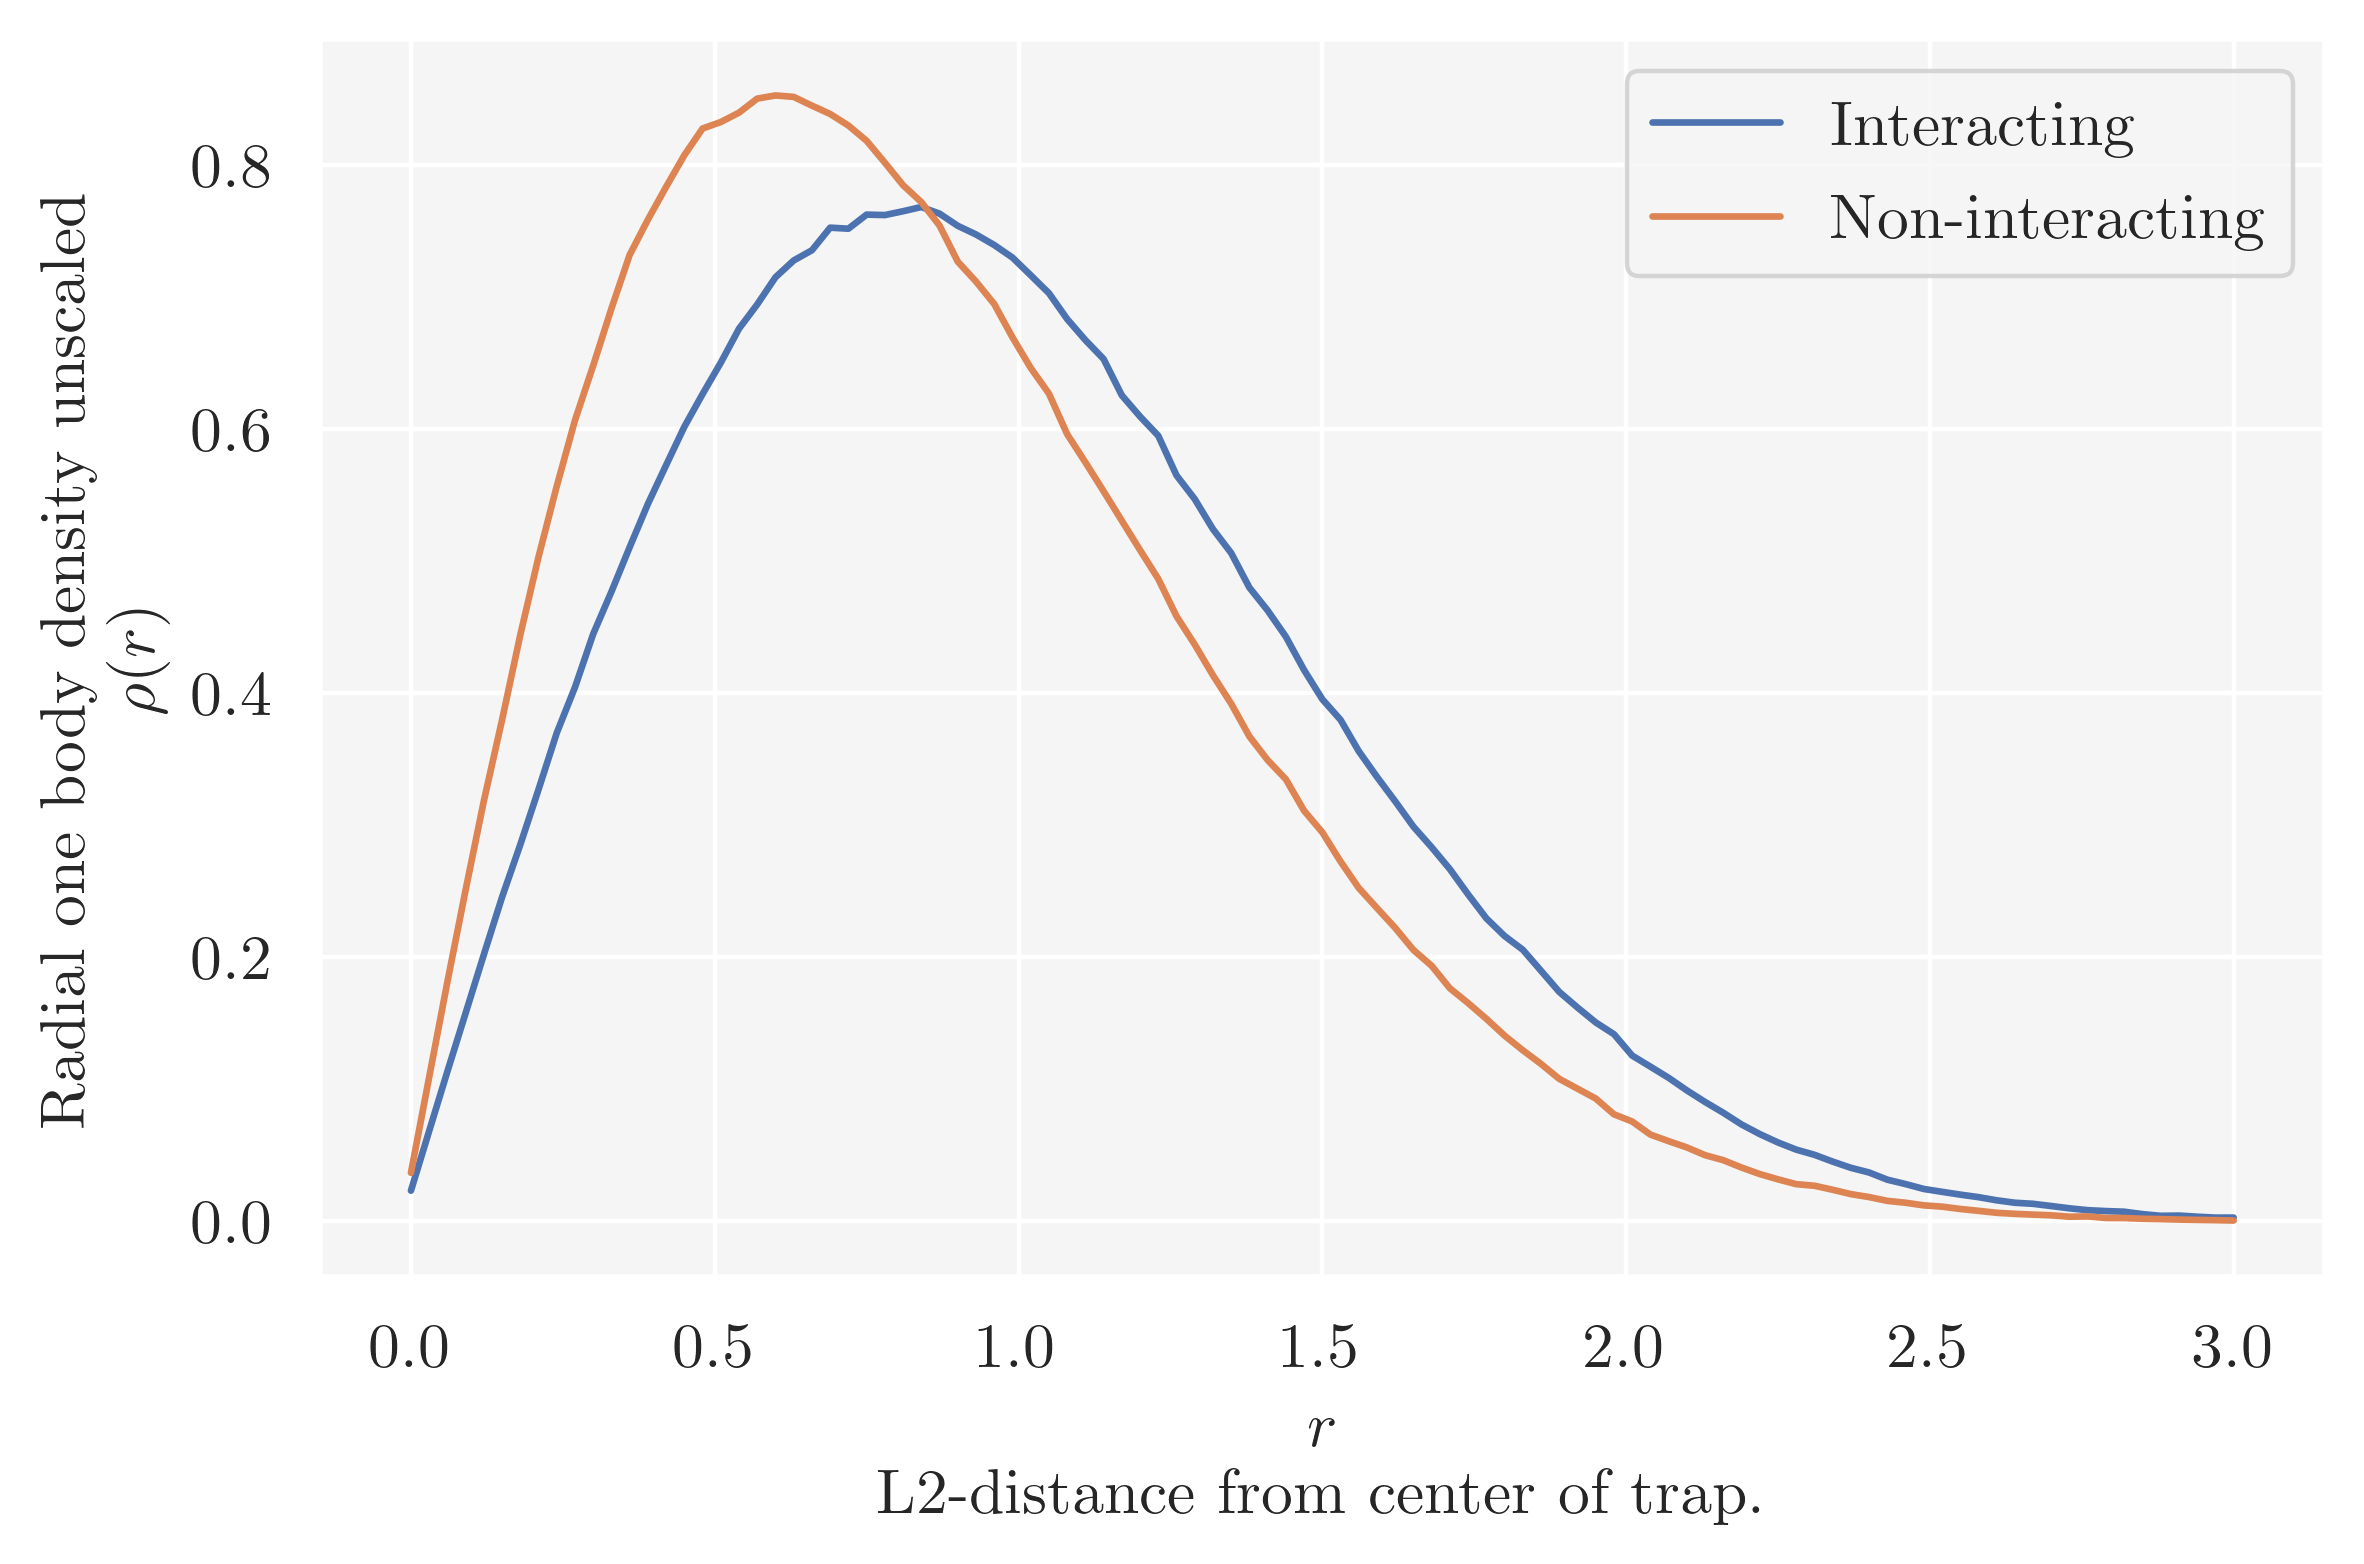

In [68]:
r_range = np.linspace(0, 3, 101)
OBD_I_ALL = 0 
OBD_NI_ALL = 0
for i in range(100): 
    OBD_I_ALL += oneBodyDensity(positions_array_I_100[:, i, :], r_range, mode="radial")
    OBD_NI_ALL += oneBodyDensity(positions_array_NI_100[:, i, :], r_range, mode="radial")
# Divide by number of particles  
OBD_NI_ALL /= 100.0 
OBD_I_ALL /=100.0
print(f"Average NI: {np.mean(position_r_NI)}")
print(f"Average I: {np.mean(position_r_I)}")
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True, dpi=200)
plt.plot(r_range, OBD_I_ALL/(2**36), label="Interacting")
plt.plot(r_range, OBD_NI_ALL/(2**36), label="Non-interacting")
tex_x = '\n'.join((r'$r$',
                 r'L2-distance from center of trap.'))
tex_y = '\n'.join(('Radial one body density unscaled', 
                  r'$\rho(r)$'))
#ax.axvline(np.mean(position_r_NI), linestyle="--", color="b", label="Average distance non-interacting")
#ax.axvline(np.mean(position_r_I), linestyle="--", color="r", label="Average distance interacting")
plt.xlabel(tex_x)
plt.ylabel(tex_y)
#plt.grid(True)
plt.legend()
plt.savefig(fig_path("OBD_N100_unscaled.pdf"), bbox_inches="tight")
plt.show()

0.9996285247802734
0.99987377166748
8.236012671847853
10.042395006045224


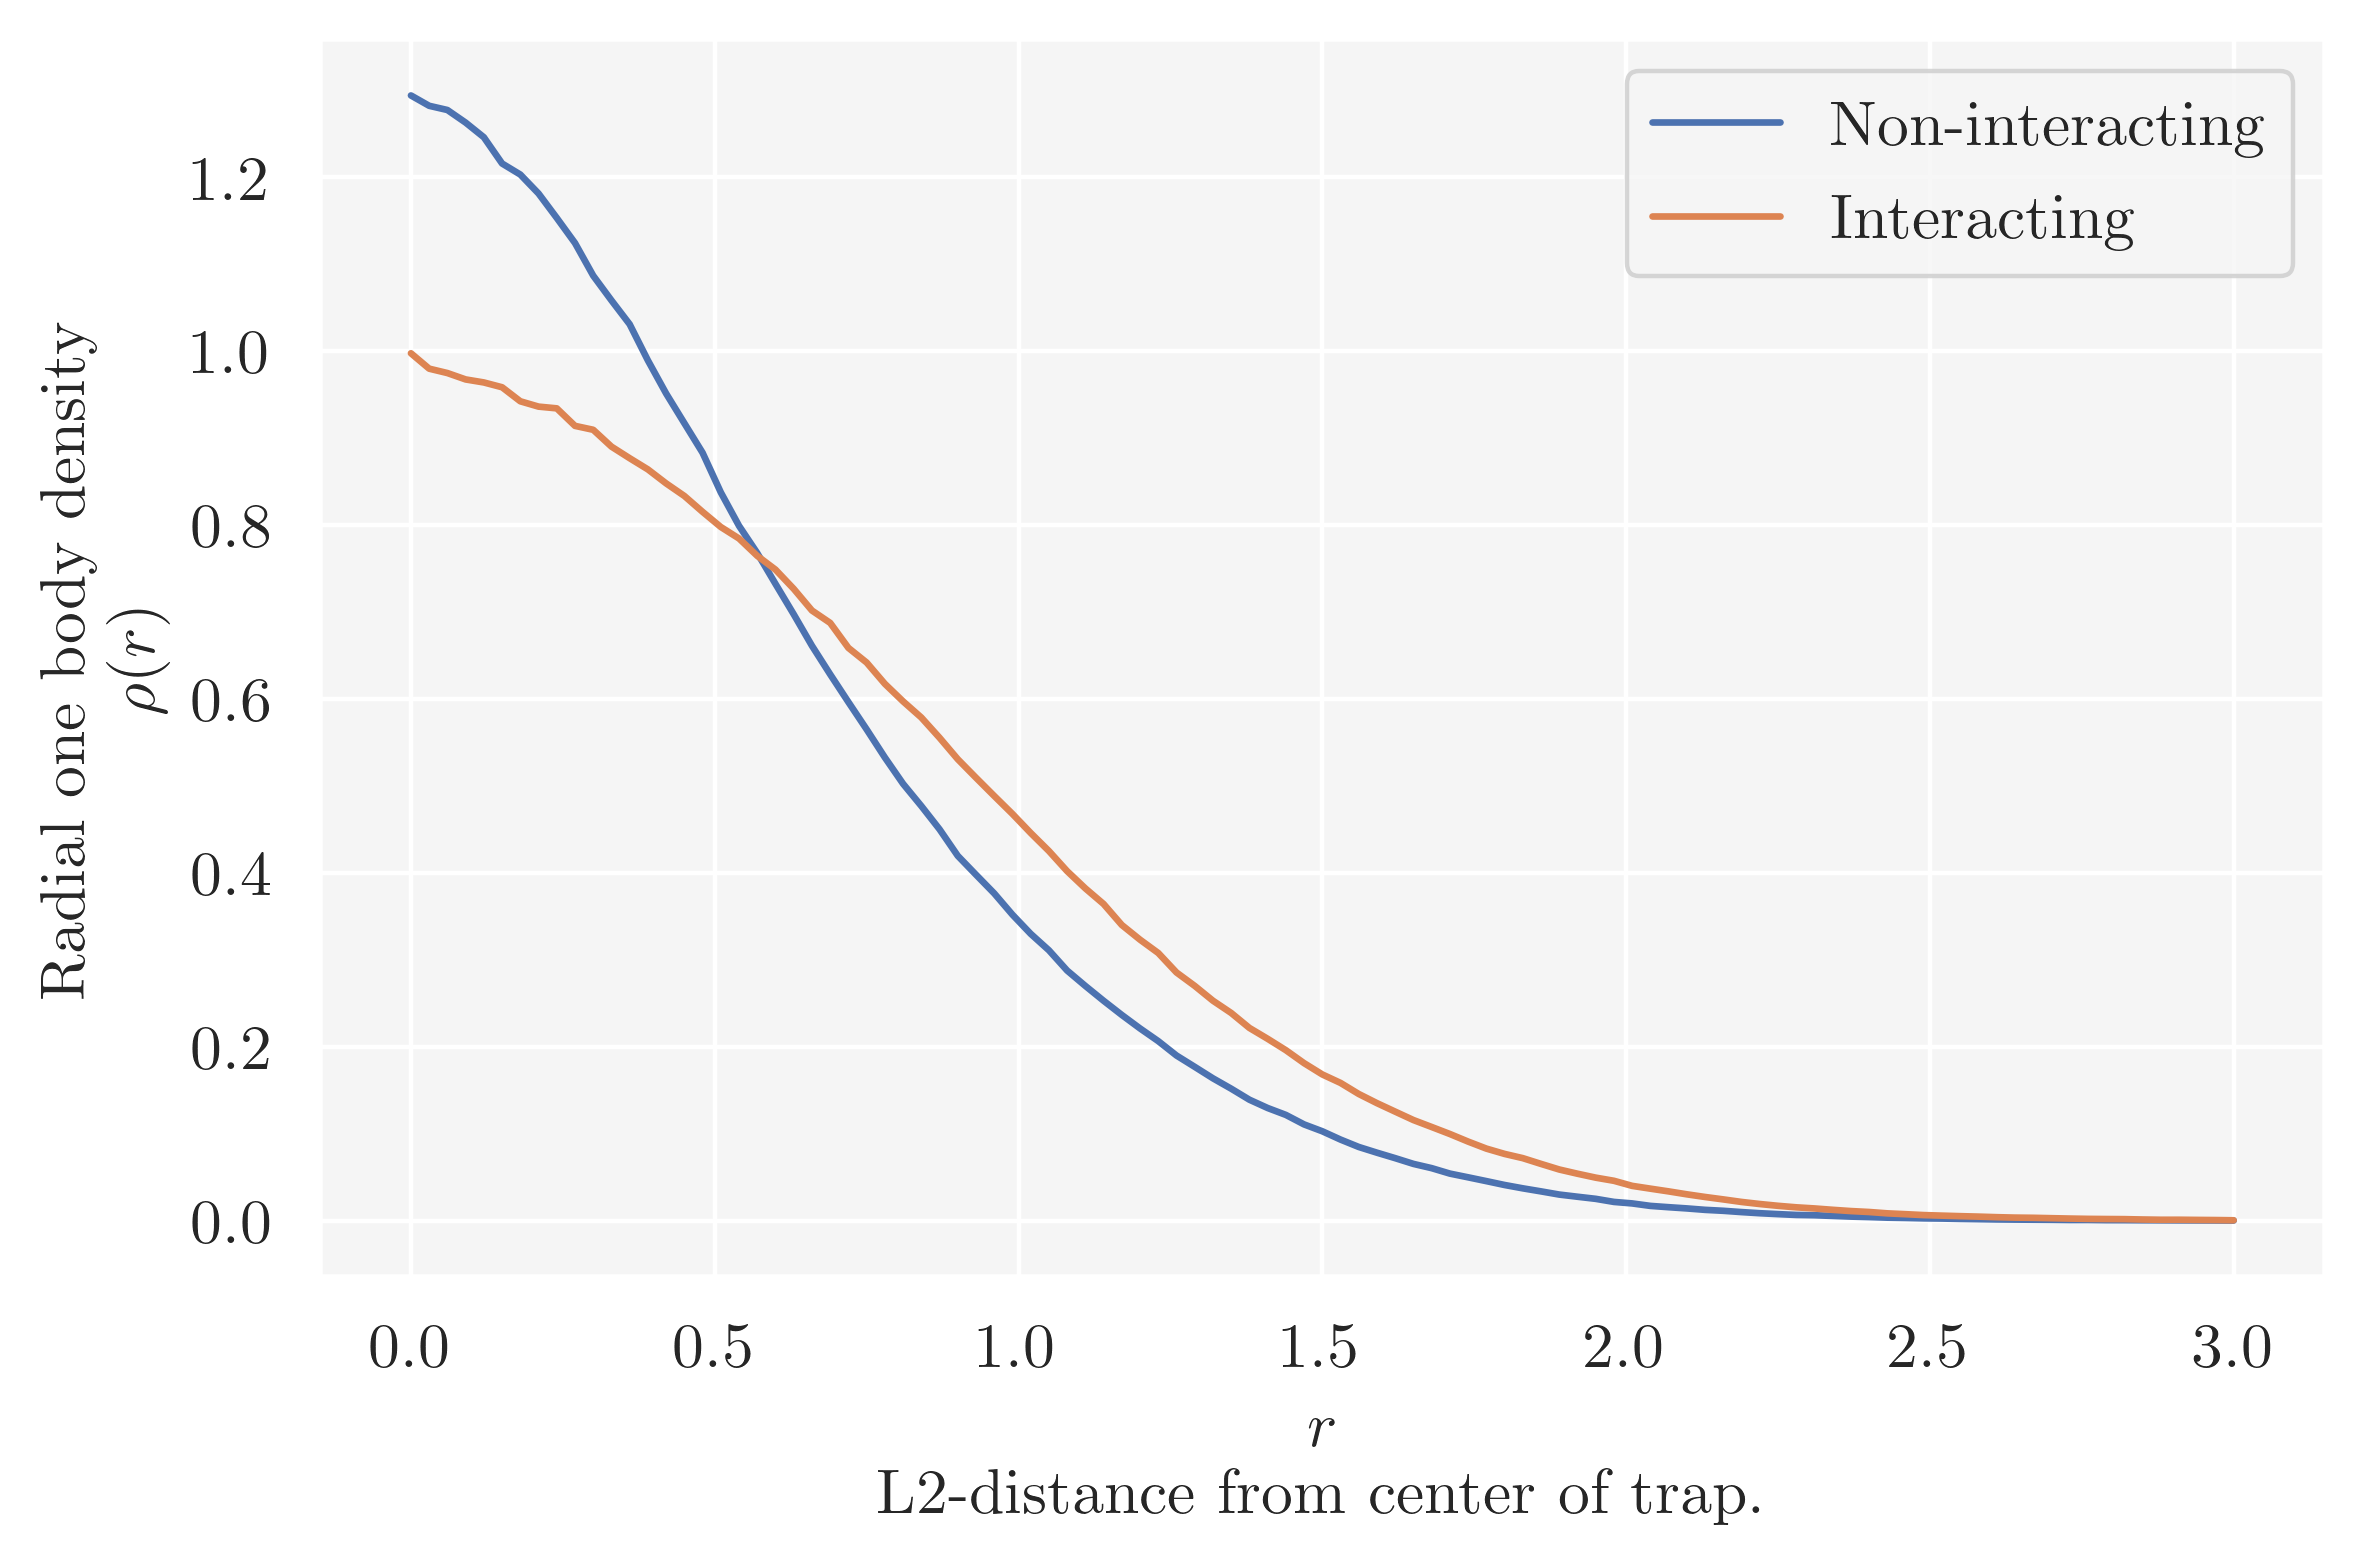

In [69]:
integral = np.sum(OBD_I_ALL/(2**36))*(r_range[1]-r_range[0])
print(integral)
integral_NI = np.sum(OBD_NI_ALL/(2**36))*(r_range[1]-r_range[0])
print(integral_NI)
def donut(r1, r2): 
    return np.pi*(r2**2-r1**2)
def shell(r1, r2): 
    return 4.0*np.pi/3.0*(r2**3 -r1**3)

r_scaler = np.ones(len(r_range))

for i in range(len(r_range)-1):
    r_scaler[i] = donut(r_range[i],r_range[i+1])
r_scaler[-1] = 1.0
scaled_OBD_NI = OBD_NI_ALL/(2**36)/r_scaler
scaled_OBD_I = OBD_I_ALL/(2**36)/r_scaler
integral_scaled = np.sum(scaled_OBD_I)*(r_range[1]-r_range[0])
print(integral_scaled)
integral_scaled_NI = np.sum(scaled_OBD_NI)*(r_range[1]-r_range[0])
print(integral_scaled_NI)
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True, dpi=200)
plt.plot(r_range, scaled_OBD_NI/integral_scaled_NI, label="Non-interacting")
plt.plot(r_range, scaled_OBD_I/integral_scaled, label="Interacting")
tex_x = '\n'.join((r'$r$',
                 r'L2-distance from center of trap.'))
tex_y = '\n'.join(('Radial one body density', 
                  r'$\rho(r)$'))
#ax.axvline(np.mean(position_r_NI), linestyle="--", color="b", label="Average distance non-interacting")
#ax.axvline(np.mean(position_r_I), linestyle="--", color="r", label="Average distance interacting")
plt.xlabel(tex_x)
plt.ylabel(tex_y)
#plt.grid(True)
plt.legend()
plt.savefig(fig_path("OBD_N100.pdf"), bbox_inches="tight")
plt.show()

### Comparison N=10

In [61]:
N = 10      # Number of particles
dim = 2      # Dimensionality
omega = 1.   # Oscillator frequency

# Exact energy 
exact_E = exact_energy(N, dim, omega)

# Instantiate wave function
wf = vmc.ASHONIB(N, dim, omega)

# Instantiate sampler
sampler = vmc.samplers.OBDMetropolis(wf)

# Config
nsamples = int(2**20)
initial_alpha = 0.5
initial_positions = safe_initial_positions_no_interactions(wf, initial_alpha, N, dim)
start = time.time()
final_state, positions_array_NI_10 = sampler.sample(nsamples,
                                                 initial_positions,
                                                 initial_alpha,
                                                 scale=1.0,  # METROPOLIS
                                                 #dt=1e-10,     # METROPOLIS-HASTINGS
                                                 nchains=1,
                                                 warm=True,
                                                 warmup_iter=20000,
                                                 tune=True,
                                                 tune_iter=20000,
                                                 tune_interval=1000,
                                                 )

end = time.time()
print("Sampler elapsed time:", end - start)




wf = vmc.ASHOIB(N, dim, omega)
sampler = vmc.samplers.OBDMetropolis(wf)
initial_positions, scale = interact_initial_positions(wf, initial_alpha, N, dim)
start = time.time()
final_state, positions_array_I_10 = sampler.sample(nsamples,
                                                initial_positions, 
                                                initial_alpha, 
                                                scale=1.0, 
                                                nchains=1, 
                                                warm=True, 
                                                warmup_iter=50000, 
                                                tune=True,
                                                tune_iter=20000,
                                                tune_interval=1000,
                                                )
end = time.time()
print("Sampler elapsed time:", end - start)

Acceptance rate=0.4554939270019531
Avg radial distance=0.8784294920321074
Sampler elapsed time: 80.67085361480713
Acceptance rate=0.5129995346069336
Avg radial distance=0.8872134435308521
Sampler elapsed time: 230.97249293327332


Average NI: 0.800994009214684
Average I: 0.9453773228541468


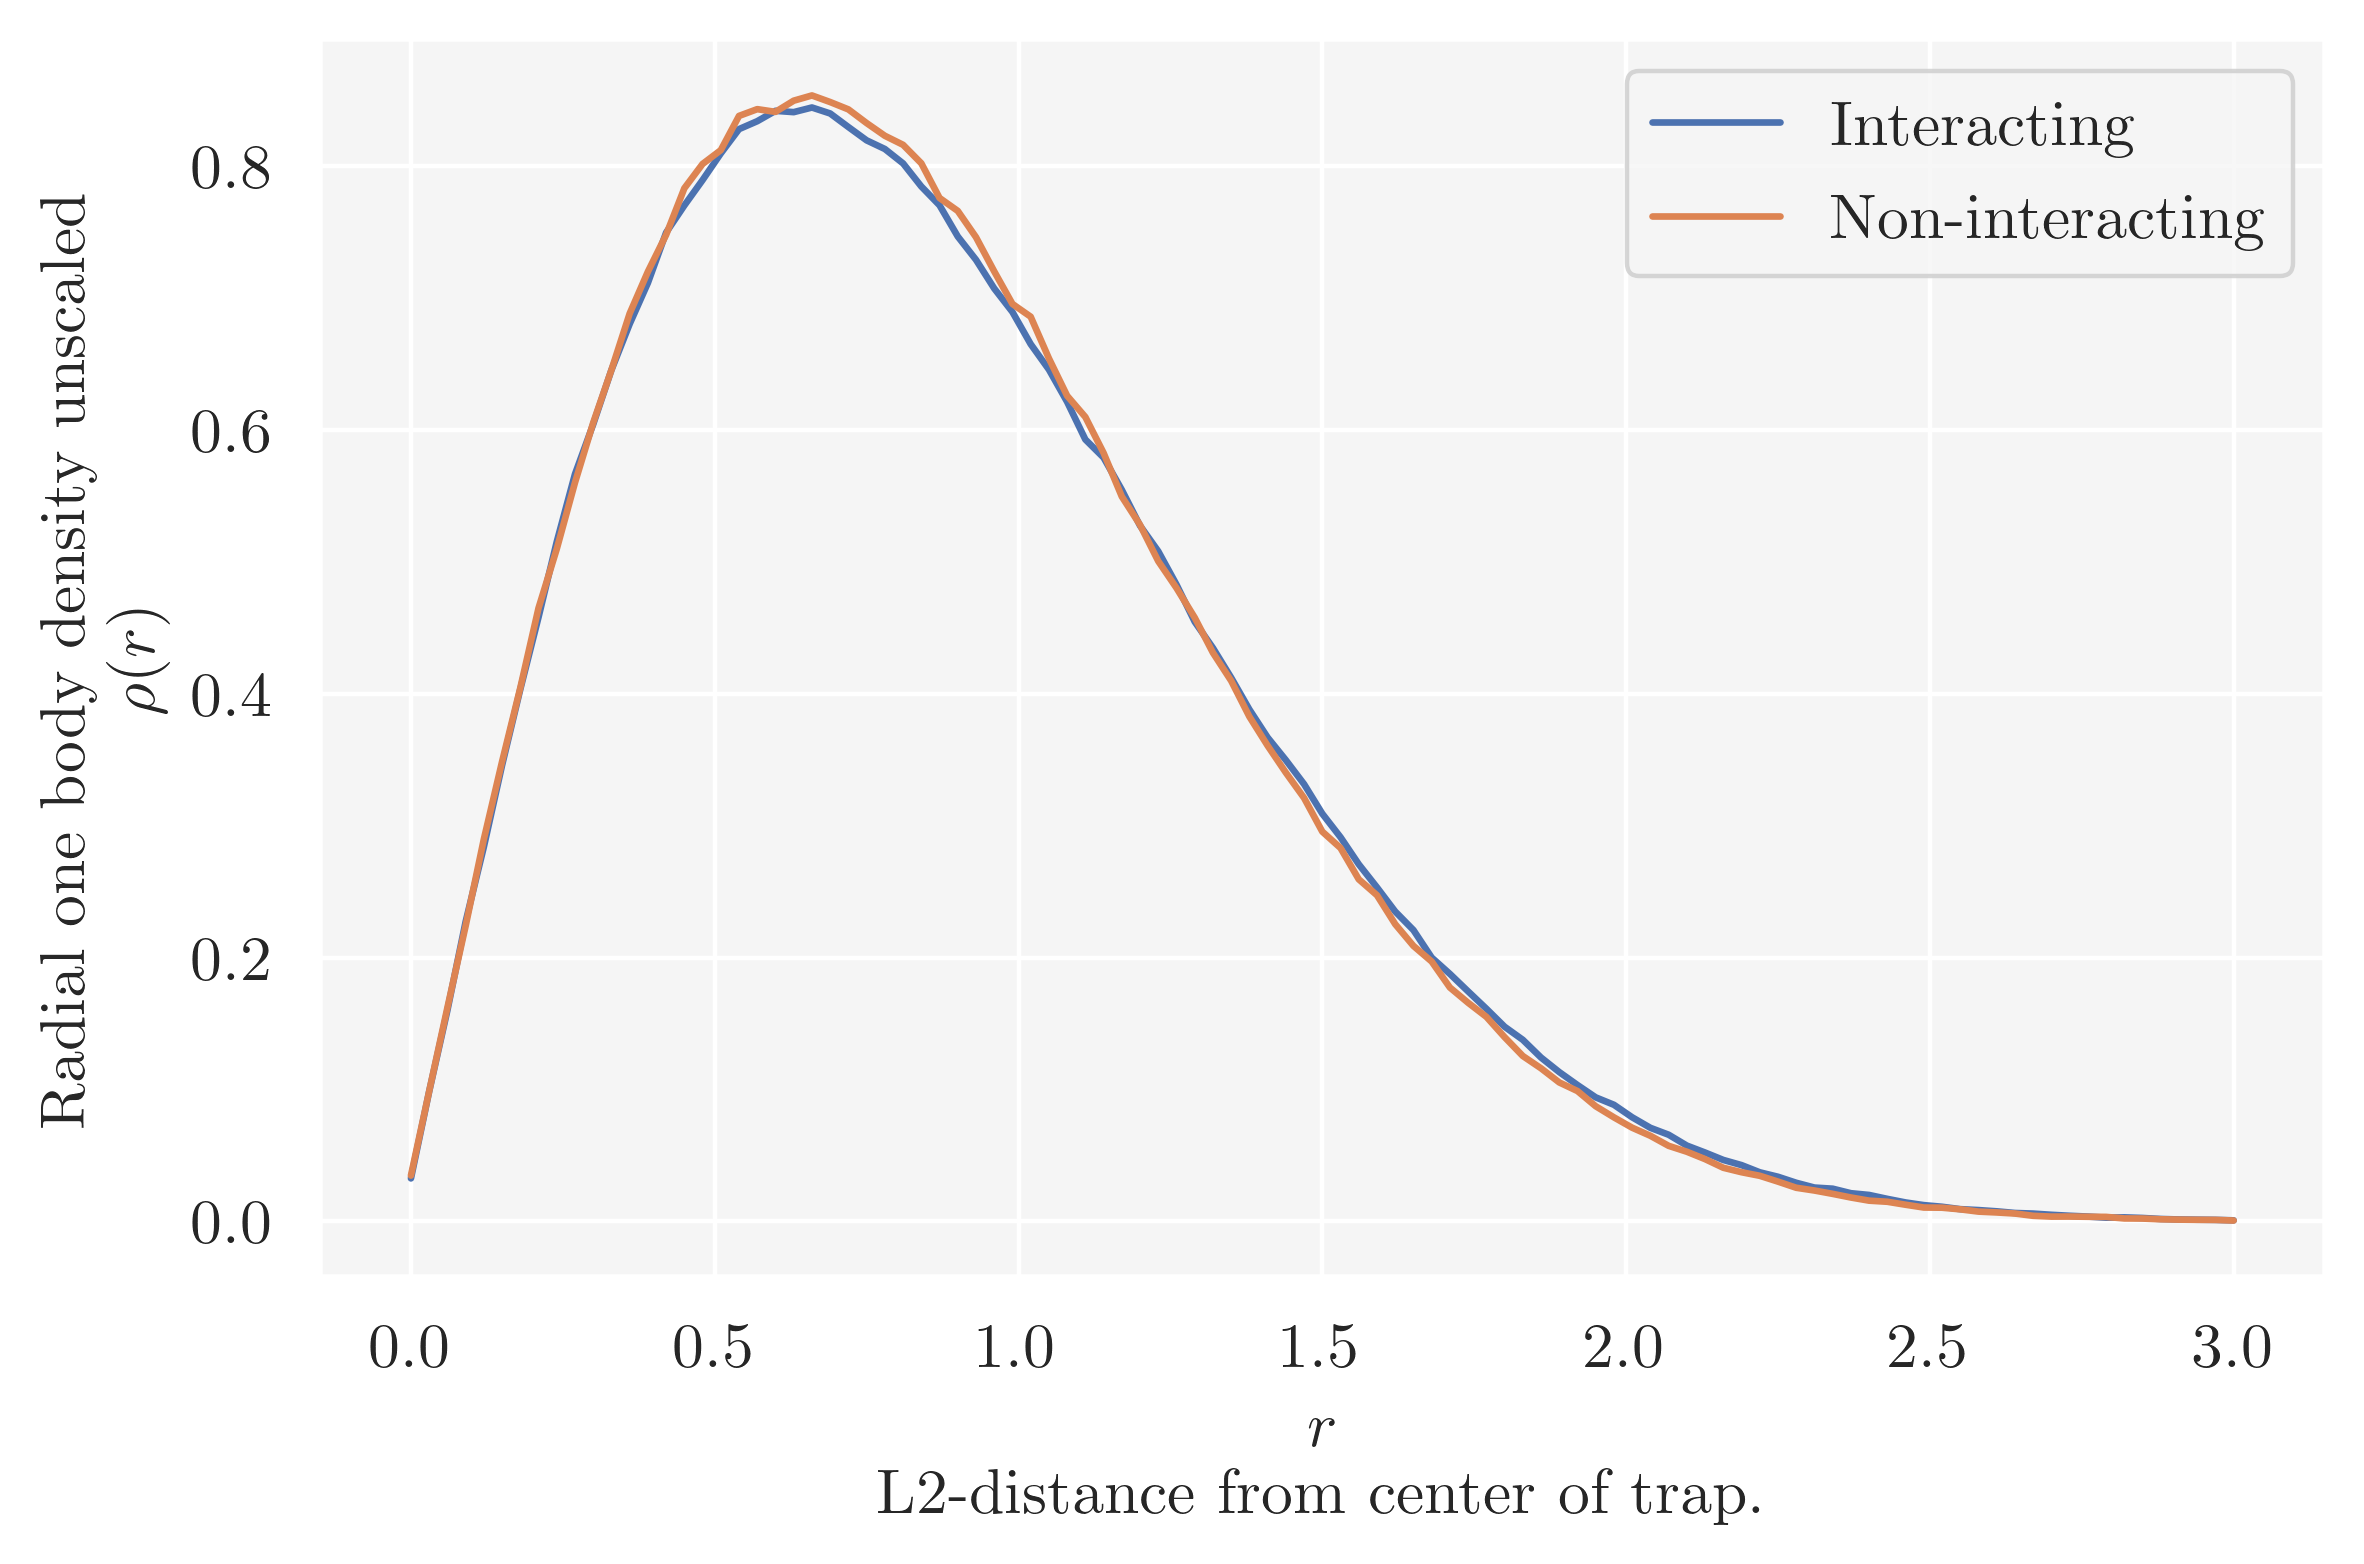

In [71]:
OBD_I_ALL = 0 
OBD_NI_ALL = 0
for i in range(10): 
    OBD_I_ALL += oneBodyDensity(positions_array_I_10[:, i, :], r_range, mode="radial")
    OBD_NI_ALL += oneBodyDensity(positions_array_NI_10[:, i, :], r_range, mode="radial")
    
OBD_NI_ALL /= 10.0
OBD_I_ALL /=10.0
print(f"Average NI: {np.mean(position_r_NI)}")
print(f"Average I: {np.mean(position_r_I)}")
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True, dpi=200)
plt.plot(r_range, OBD_I_ALL/(2**40), label="Interacting")
plt.plot(r_range, OBD_NI_ALL/(2**40), label="Non-interacting")
tex_x = '\n'.join((r'$r$',
                 r'L2-distance from center of trap.'))
tex_y = '\n'.join(('Radial one body density unscaled', 
                  r'$\rho(r)$'))
#ax.axvline(np.mean(position_r_NI), linestyle="--", color="b", label="Average distance non-interacting")
#ax.axvline(np.mean(position_r_I), linestyle="--", color="r", label="Average distance interacting")
plt.xlabel(tex_x)
plt.ylabel(tex_y)
#plt.yticks([])
#plt.xticks([])
plt.grid(True)
plt.legend()
plt.savefig(fig_path("OBD_N10_unscaled.pdf"), bbox_inches="tight")
plt.show()

0.9998198509216307
0.9998769760131838
9.635850305609672
9.700965929631757


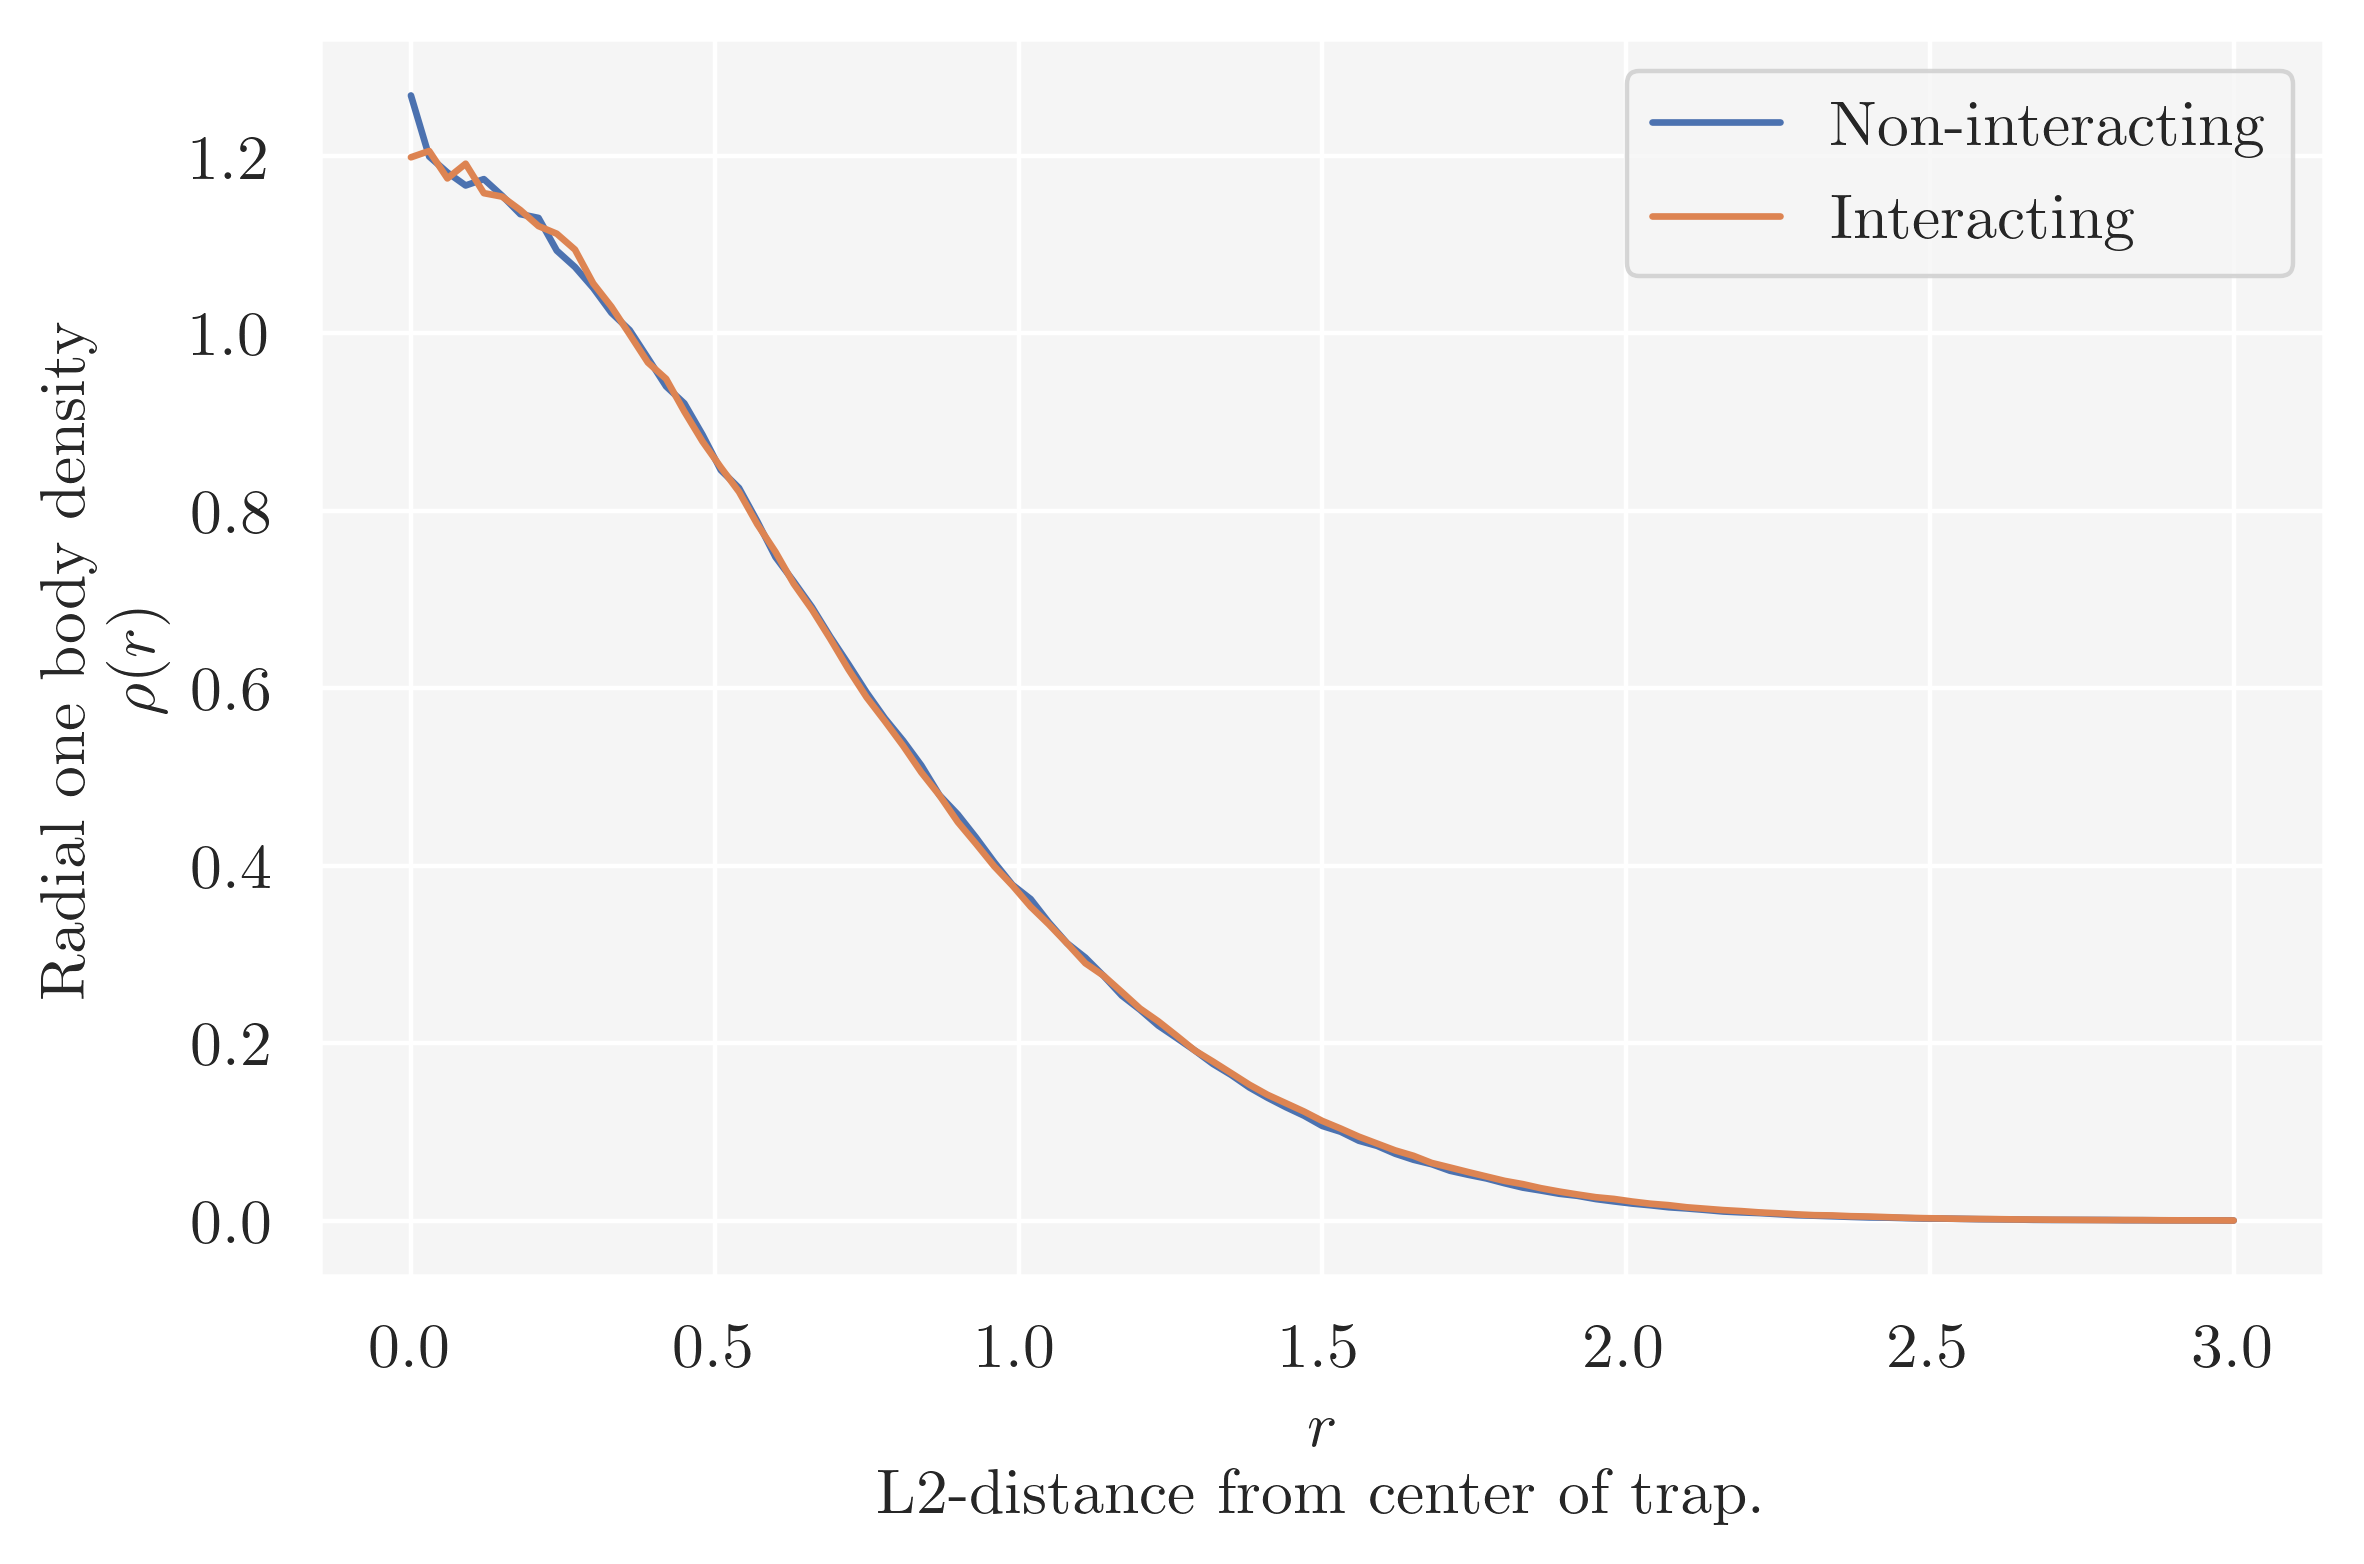

In [72]:
integral = np.sum(OBD_I_ALL/(2**40))*(r_range[1]-r_range[0])
print(integral)
integral_NI = np.sum(OBD_NI_ALL/(2**40))*(r_range[1]-r_range[0])
print(integral_NI)

r_scaler = np.ones(len(r_range))

for i in range(len(r_range)-1):
    r_scaler[i] = donut(r_range[i],r_range[i+1])
r_scaler[-1] = 1.0
scaled_OBD_NI = OBD_NI_ALL/(2**40)/r_scaler
scaled_OBD_I = OBD_I_ALL/(2**40)/r_scaler
integral_scaled = np.sum(scaled_OBD_I)*(r_range[1]-r_range[0])
print(integral_scaled)
integral_scaled_NI = np.sum(scaled_OBD_NI)*(r_range[1]-r_range[0])
print(integral_scaled_NI)
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True, dpi=200)
plt.plot(r_range, scaled_OBD_NI/integral_scaled_NI, label="Non-interacting")
plt.plot(r_range, scaled_OBD_I/integral_scaled, label="Interacting")
tex_x = '\n'.join((r'$r$',
                 r'L2-distance from center of trap.'))
tex_y = '\n'.join(('Radial one body density', 
                  r'$\rho(r)$'))
#ax.axvline(np.mean(position_r_NI), linestyle="--", color="b", label="Average distance non-interacting")
#ax.axvline(np.mean(position_r_I), linestyle="--", color="r", label="Average distance interacting")
plt.xlabel(tex_x)
plt.ylabel(tex_y)
#plt.grid(True)
plt.legend()
plt.savefig(fig_path("OBD_N10.pdf"), bbox_inches="tight")
plt.show()

In [11]:
N = 10     # Number of particles
dim = 2      # Dimensionality
omega = 1.   # Oscillator frequency

# Exact energy 
exact_E = exact_energy(N, dim, omega)

# Instantiate wave function
wf = vmc.ASHONIB(N, dim, omega)

# Instantiate sampler
sampler = vmc.samplers.OBDMetropolis(wf)

# Config
nsamples = int(1e6)
initial_alpha = 0.5
initial_positions = safe_initial_positions_no_interactions(wf, initial_alpha, N, dim)
start = time.time()
final_state, positions_array_NI = sampler.sample(nsamples,
                                                 initial_positions,
                                                 initial_alpha,
                                                 scale=1.0,  # METROPOLIS
                                                 #dt=1e-10,     # METROPOLIS-HASTINGS
                                                 nchains=1,
                                                 warm=True,
                                                 warmup_iter=20000,
                                                 tune=True,
                                                 tune_iter=10000,
                                                 tune_interval=500,
                                                 )

end = time.time()
print("Sampler elapsed time:", end - start)




wf = vmc.ASHOIB(N, dim, omega)
sampler = vmc.samplers.OBDMetropolis(wf)
initial_positions, scale = interact_initial_positions(wf, initial_alpha, N, dim)
start = time.time()
final_state, positions_array_I = sampler.sample(nsamples,
                                                initial_positions, 
                                                initial_alpha, 
                                                scale=1.0, 
                                                nchains=1, 
                                                warm=True, 
                                                warmup_iter=50000, 
                                                tune=True,
                                                tune_iter=10000,
                                                tune_interval=500,
                                                )
end = time.time()
print("Sampler elapsed time:", end - start)

Acceptance rate=0.454951
Avg radial distance=0.8796602741992231
Sampler elapsed time: 92.64670014381409
Acceptance rate=0.511339
Avg radial distance=0.8917066742054113
Sampler elapsed time: 239.54530096054077


Average NI: 0.8263128490997901
Average I: 0.8347947982740764


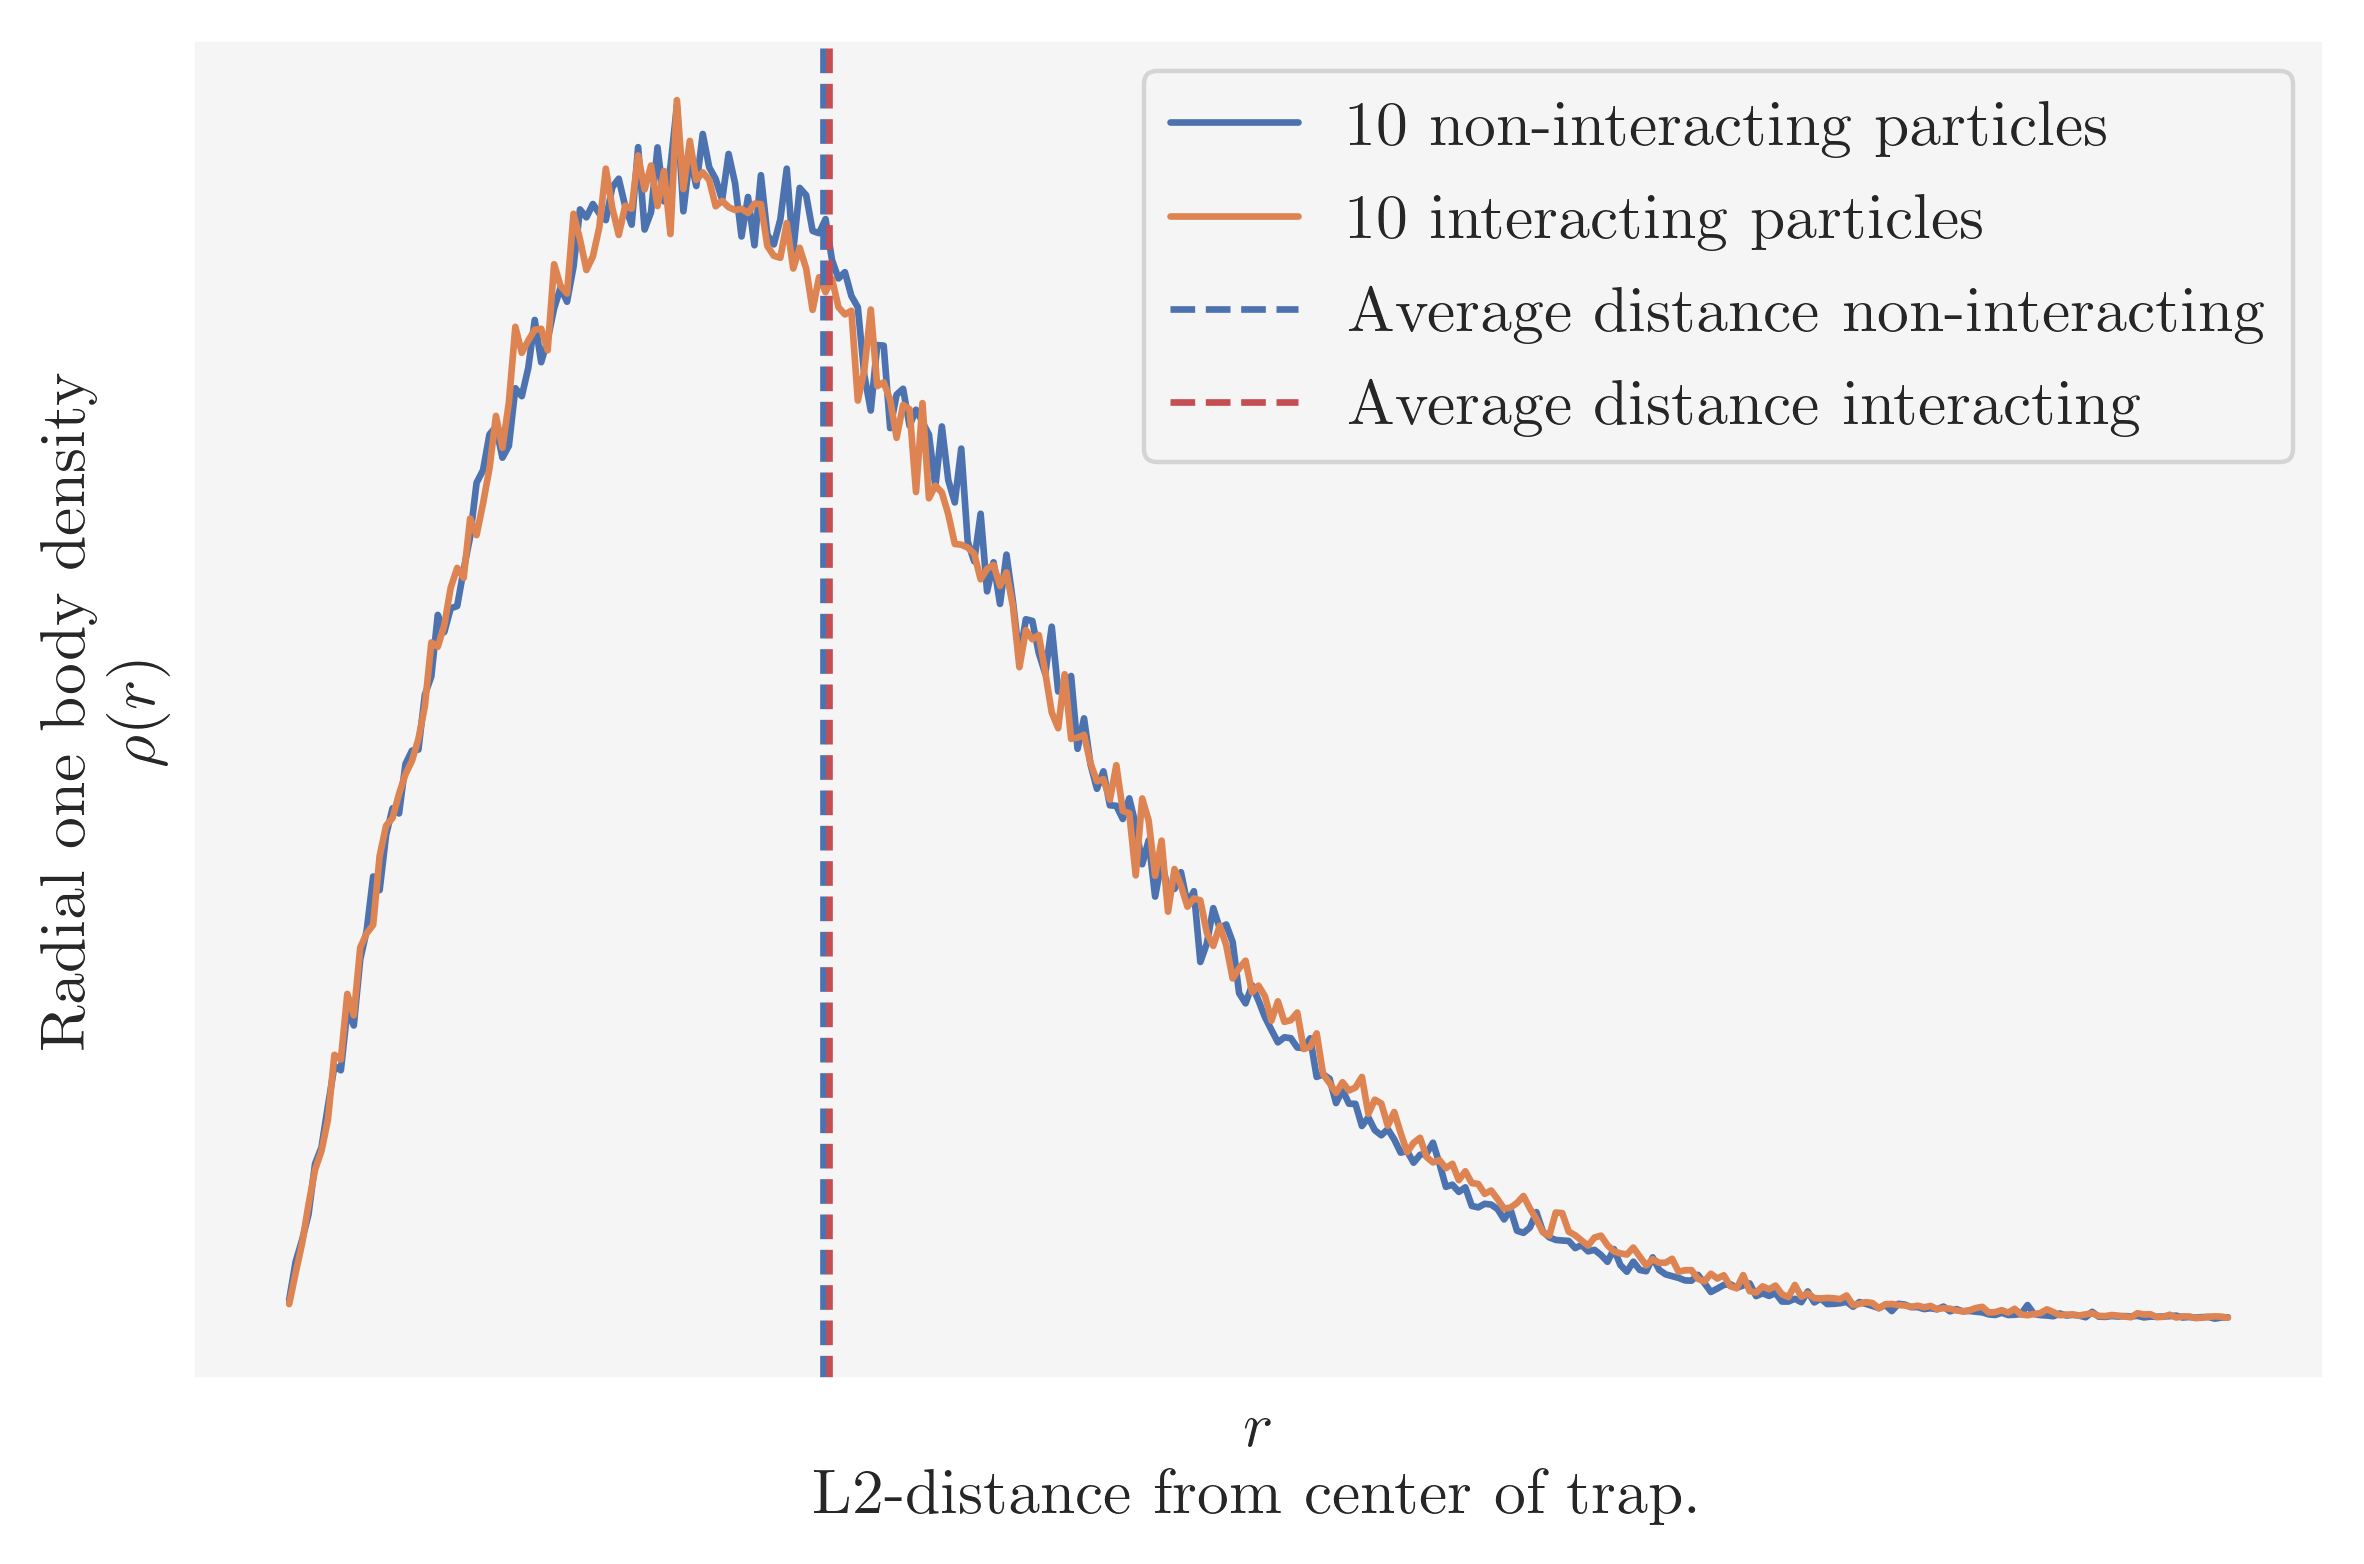

In [12]:
r_range = np.linspace(0, 3, 301)
position_r_NI = np.linalg.norm(positions_array_NI[:, 1, :], axis=1)
position_r_I = np.linalg.norm(positions_array_I[:, 1, :], axis=1)
OBD_NI = oneBodyDensity(positions_array_NI[:, 1, :], r_range, mode="radial")
OBD_I = oneBodyDensity(positions_array_I[:, 1, :], r_range, mode="radial")

print(f"Average NI: {np.mean(position_r_NI)}")
print(f"Average I: {np.mean(position_r_I)}")
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True, dpi=200)
plt.plot(r_range, OBD_NI/(1e6), label="10 non-interacting particles")
plt.plot(r_range, OBD_I/(1e6), label="10 interacting particles")
tex_x = '\n'.join((r'$r$',
                 r'L2-distance from center of trap.'))
tex_y = '\n'.join(('Radial one body density', 
                  r'$\rho(r)$'))
ax.axvline(np.mean(position_r_NI), linestyle="--", color="b", label="Average distance non-interacting")
ax.axvline(np.mean(position_r_I), linestyle="--", color="r", label="Average distance interacting")
plt.xlabel(tex_x)
plt.ylabel(tex_y)
plt.yticks([])
plt.xticks([])
plt.grid(True)
plt.legend()
plt.savefig(fig_path("OBD_N10.pdf"), bbox_inches="tight")
plt.show()

In [48]:
N = 1       # Number of particles
dim = 1      # Dimensionality
omega = 1.   # Oscillator frequency

# Exact energy 
exact_E = exact_energy(N, dim, omega)

# Instantiate wave function
wf = vmc.ASHONIB(N, dim, omega)

# Instantiate sampler
sampler_NI_N10 = vmc.samplers.Metropolis(wf)

# Config
nsamples = int(1e6)
initial_alpha = 0.5
initial_positions = safe_initial_positions_no_interactions(wf, initial_alpha, N, dim)
start = time.time()
results, positions_array_NI = sampler_NI_N10.sample(nsamples,
                                                    initial_positions,
                                                    initial_alpha,
                                                    scale=1.0,  # METROPOLIS
                                                    #dt=1e-10,     # METROPOLIS-HASTINGS
                                                    nchains=1,
                                                    warm=True,
                                                    warmup_iter=20000,
                                                    tune=True,
                                                    tune_iter=10000,
                                                    tune_interval=500,
                                                    tol_tune=1e-5,
                                                    optimize=False,
                                                    )

end = time.time()
print("Sampler elapsed time:", end - start)
# Saving distances in flattened matrix


wf = vmc.ASHOIB(N, dim, omega)
sampler_I_N10 = vmc.samplers.Metropolis(wf)
initial_positions, scale = interact_initial_positions(wf, initial_alpha, N, dim)
start = time.time()
results, positions_array_I = sampler_I_N10.sample(nsamples,
                                                  initial_positions, 
                                                  initial_alpha, 
                                                  scale=1.0, 
                                                  nchains=1, 
                                                  warm=True, 
                                                  warmup_iter=20000, 
                                                  tune=True,
                                                  tune_iter=10000,
                                                  tune_interval=500,
                                                  tol_tune=100,
                                                  optimize=False,
                                                  )
end = time.time()
print("Sampler elapsed time:", end - start)


Warm done
Tune done
Warm after tune done
Sampling energy
Sampler elapsed time: 86.68317580223083
Warm done
Tune done
Warm after tune done
Sampling energy
Sampler elapsed time: 735.6628849506378


Shape of densities:  (201, 201)
Min_X=-2.0, min_y=-2.0
Shape of densities:  (201, 201)
Min_X=-2.0, min_y=-2.0


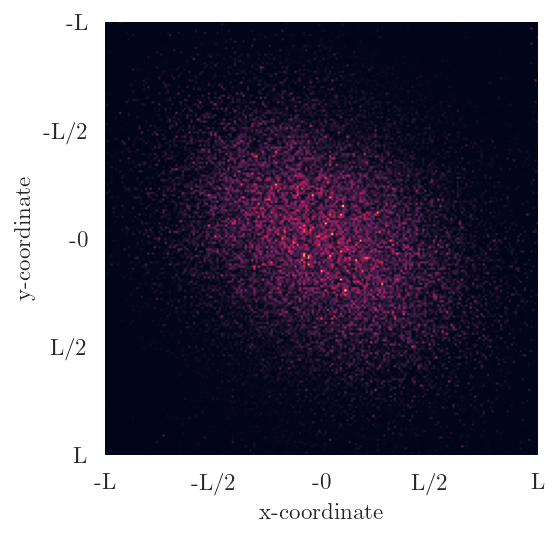

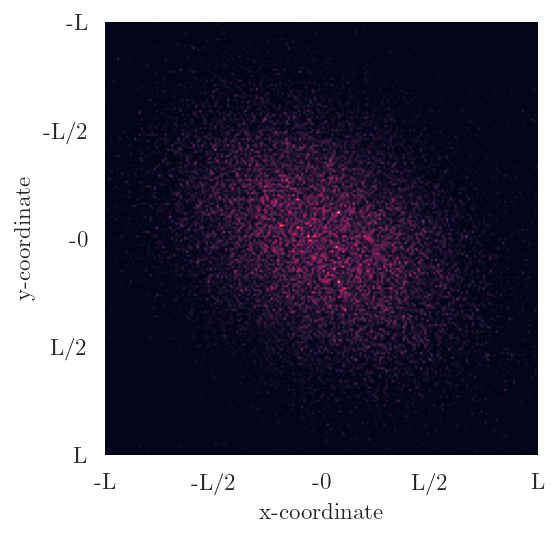

In [47]:
xy_range = np.linspace(-5, 5, 201)
OBdensity_NI = one_body_density(positions_array_NI[:, 0, :], xy_range)
OBdensity_I = one_body_density(positions_array_I[:, 0, :], xy_range)

fig = plt.figure()
plt.imshow(OBdensity_NI)
plt.xticks([0, 50, 100, 150, 200], labels=["-L", "-L/2", "-0", "L/2", "L"])
plt.yticks([0, 50, 100, 150, 200], labels=["-L", "-L/2", "-0", "L/2", "L"])
plt.xlabel("x-coordinate")
plt.ylabel("y-coordinate")
plt.grid(False)
fig.savefig(fig_path("OBD_1NI.pdf"), bbox_inches="tight")
plt.show()

fig = plt.figure()
plt.imshow(OBdensity_I)
plt.xticks([0, 50, 100, 150, 200], labels=["-L", "-L/2", "-0", "L/2", "L"])
plt.yticks([0, 50, 100, 150, 200], labels=["-L", "-L/2", "-0", "L/2", "L"])
plt.xlabel("x-coordinate")
plt.ylabel("y-coordinate")
plt.grid(False)
fig.savefig(fig_path("OBD_1I.pdf"), bbox_inches="tight")
plt.show()

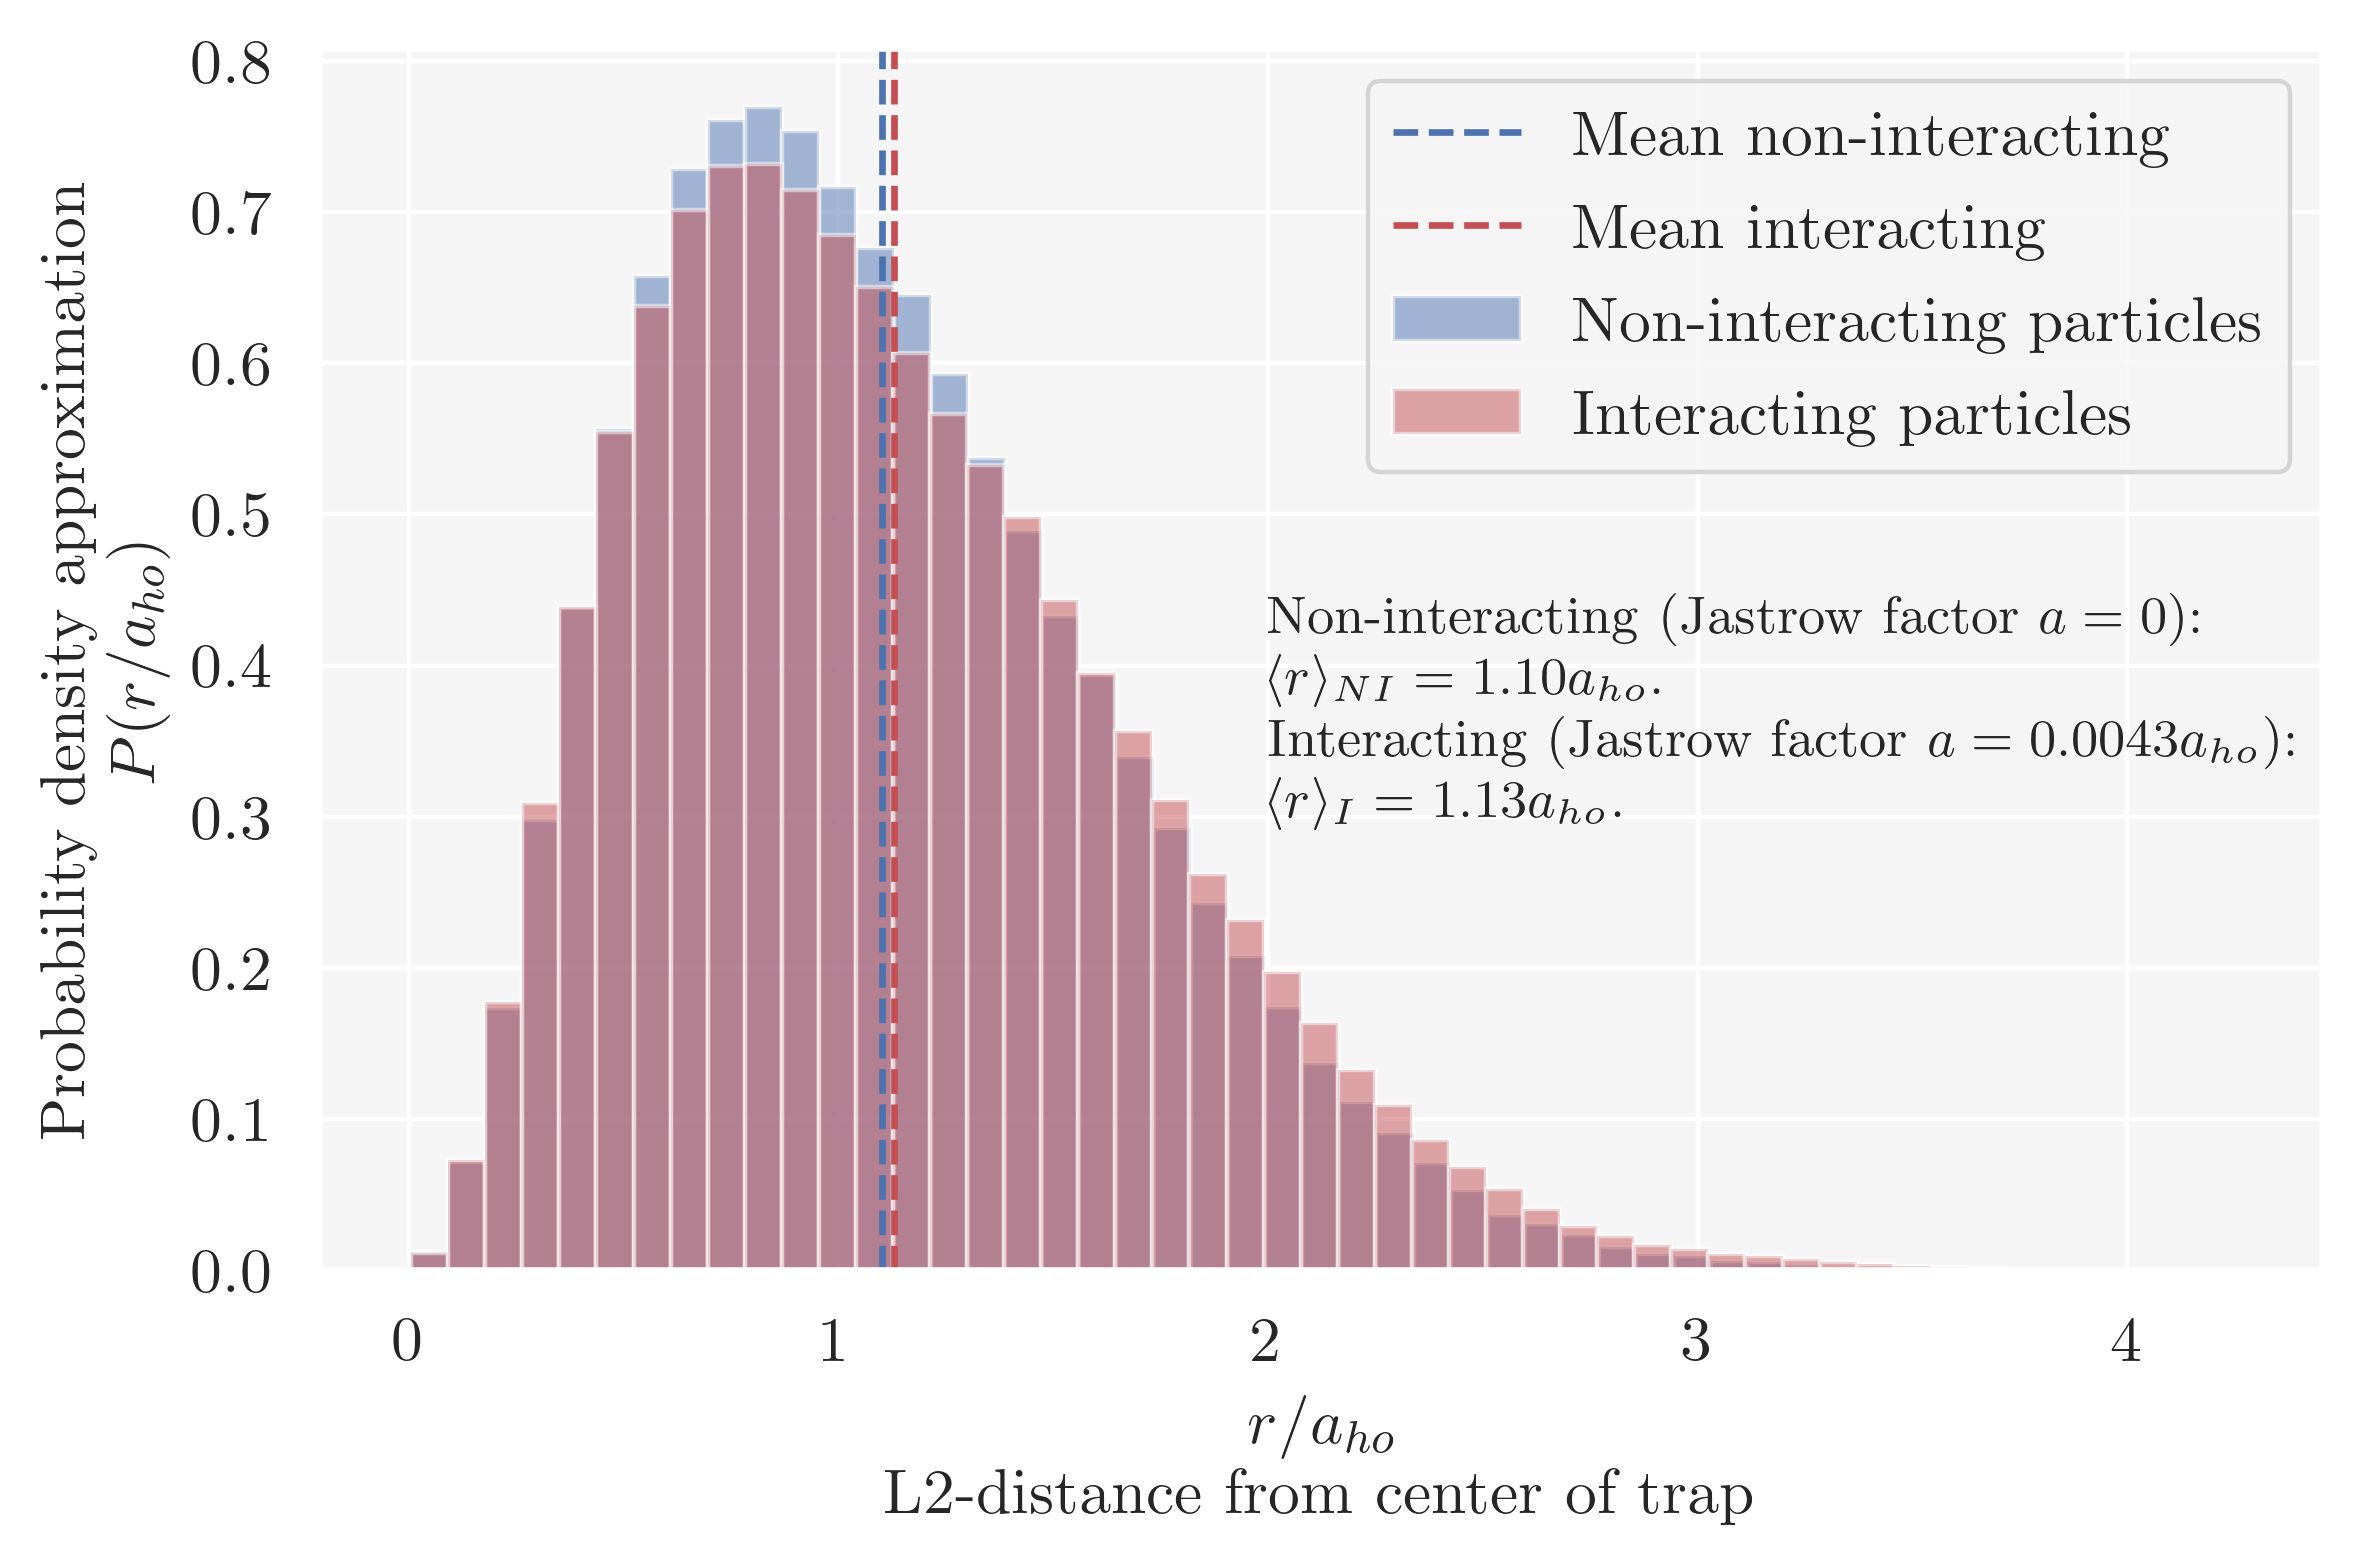

In [64]:
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True, dpi=200)
n, bins, patches = plt.hist(x=distances_NI_N10, bins=np.linspace(np.min(distances_NI_N10), np.max(distances_NI_N10), 50), density=True, color='b',
                            alpha=0.5, label="Non-interacting particles")
n, bins, patches = plt.hist(x=distances_I_N10, bins=np.linspace(np.min(distances_I_N10), np.max(distances_I_N10), 50), density=True, color='r',
                            alpha=0.5, label="Interacting particles")
plt.grid(True)
tex_xlabel = '\n'.join((r'$r/a_{ho}$',
                       'L2-distance from center of trap'))
tex_ylabel = '\n'.join(('Probability density approximation', 
                        r'$P(r/a_{ho})$'))
plt.xlabel(tex_xlabel)
plt.ylabel(tex_ylabel)
texstr = '\n'.join((r'Non-interacting (Jastrow factor $a=0$):',
                    r'$\quad\quad\quad\quad\langle r\rangle_{NI} = %.2fa_{ho}.$'%(np.mean(distances_NI_N10)),
                    r'Interacting (Jastrow factor $a=0.0043 a_{ho}$):',
                    r'$\quad\quad\quad\quad\langle r\rangle_{I} = %.2f a_{ho}.$'%(np.mean(distances_I_N10))))
#plt.text(2.3, 0.42, r'$\langle r_N\rangle=%.2f a_{ho}$'%(np.mean(distances_NI_N10)))
#plt.text(2.3, 0.38, r'$\langle r_I\rangle=%.2f a_{ho}$'%(np.mean(distances_I_N10)))
plt.text(2.0, 0.3, texstr)
ax.axvline(np.mean(distances_NI_N10), linestyle="--", color="b", label="Mean non-interacting")
ax.axvline(np.mean(distances_I_N10), linestyle="--", color="r", label="Mean interacting")
plt.legend()

fig.savefig(fig_path("OBD_10.pdf"), bbox_inches='tight')

## Comparison N=50

In [5]:
N = 50       # Number of particles
dim = 3      # Dimensionality
omega = 1.   # Oscillator frequency

# Exact energy 
exact_E = exact_energy(N, dim, omega)

# Instantiate wave function
wf = vmc.ASHONIB(N, dim, omega)

# Instantiate sampler
sampler_NI_N50 = vmc.samplers.Metropolis(wf)

# Config
nsamples = int(2**17)
initial_alpha = 0.5
initial_positions = safe_initial_positions_no_interactions(wf, initial_alpha, N, dim)
start = time.time()
results = sampler_NI_N50.sample(nsamples,
                         initial_positions,
                         initial_alpha,
                         scale=1.0,  # METROPOLIS
                         #dt=1e-10,     # METROPOLIS-HASTINGS
                         nchains=1,
                         warm=True,
                         warmup_iter=5000,
                         tune=True,
                         tune_iter=10000,
                         tune_interval=500,
                         tol_tune=1e-5,
                         optimize=False,
                         )

end = time.time()
print("Sampler elapsed time:", end - start)
# Saving distances in flattened matrix
distances_NI_N50 = sampler_NI_N50.distance_samples.flatten()

wf = vmc.ASHOIB(N, dim, omega)
sampler_I_N50 = vmc.samplers.Metropolis(wf)
initial_positions, scale = interact_initial_positions(wf, initial_alpha, N, dim)
start = time.time()
results = sampler_I_N50.sample(nsamples,
                              initial_positions, 
                              initial_alpha, 
                              scale=1.0, 
                              nchains=1, 
                              warm=True, 
                              warmup_iter=10000, 
                              tune=True,
                              tune_iter=10000,
                              tune_interval=500,
                              tol_tune=100,
                              optimize=False,
                              )
end = time.time()
print("Sampler elapsed time:", end - start)
distances_I_N50 = sampler_I_N50.distance_samples.flatten()

Warm done
Tune done
Warm after tune done
Sampling energy
Sampler elapsed time: 29.87003445625305
Warm done
Tune done
Warm after tune done
Sampling energy
Sampler elapsed time: 361.4858384132385


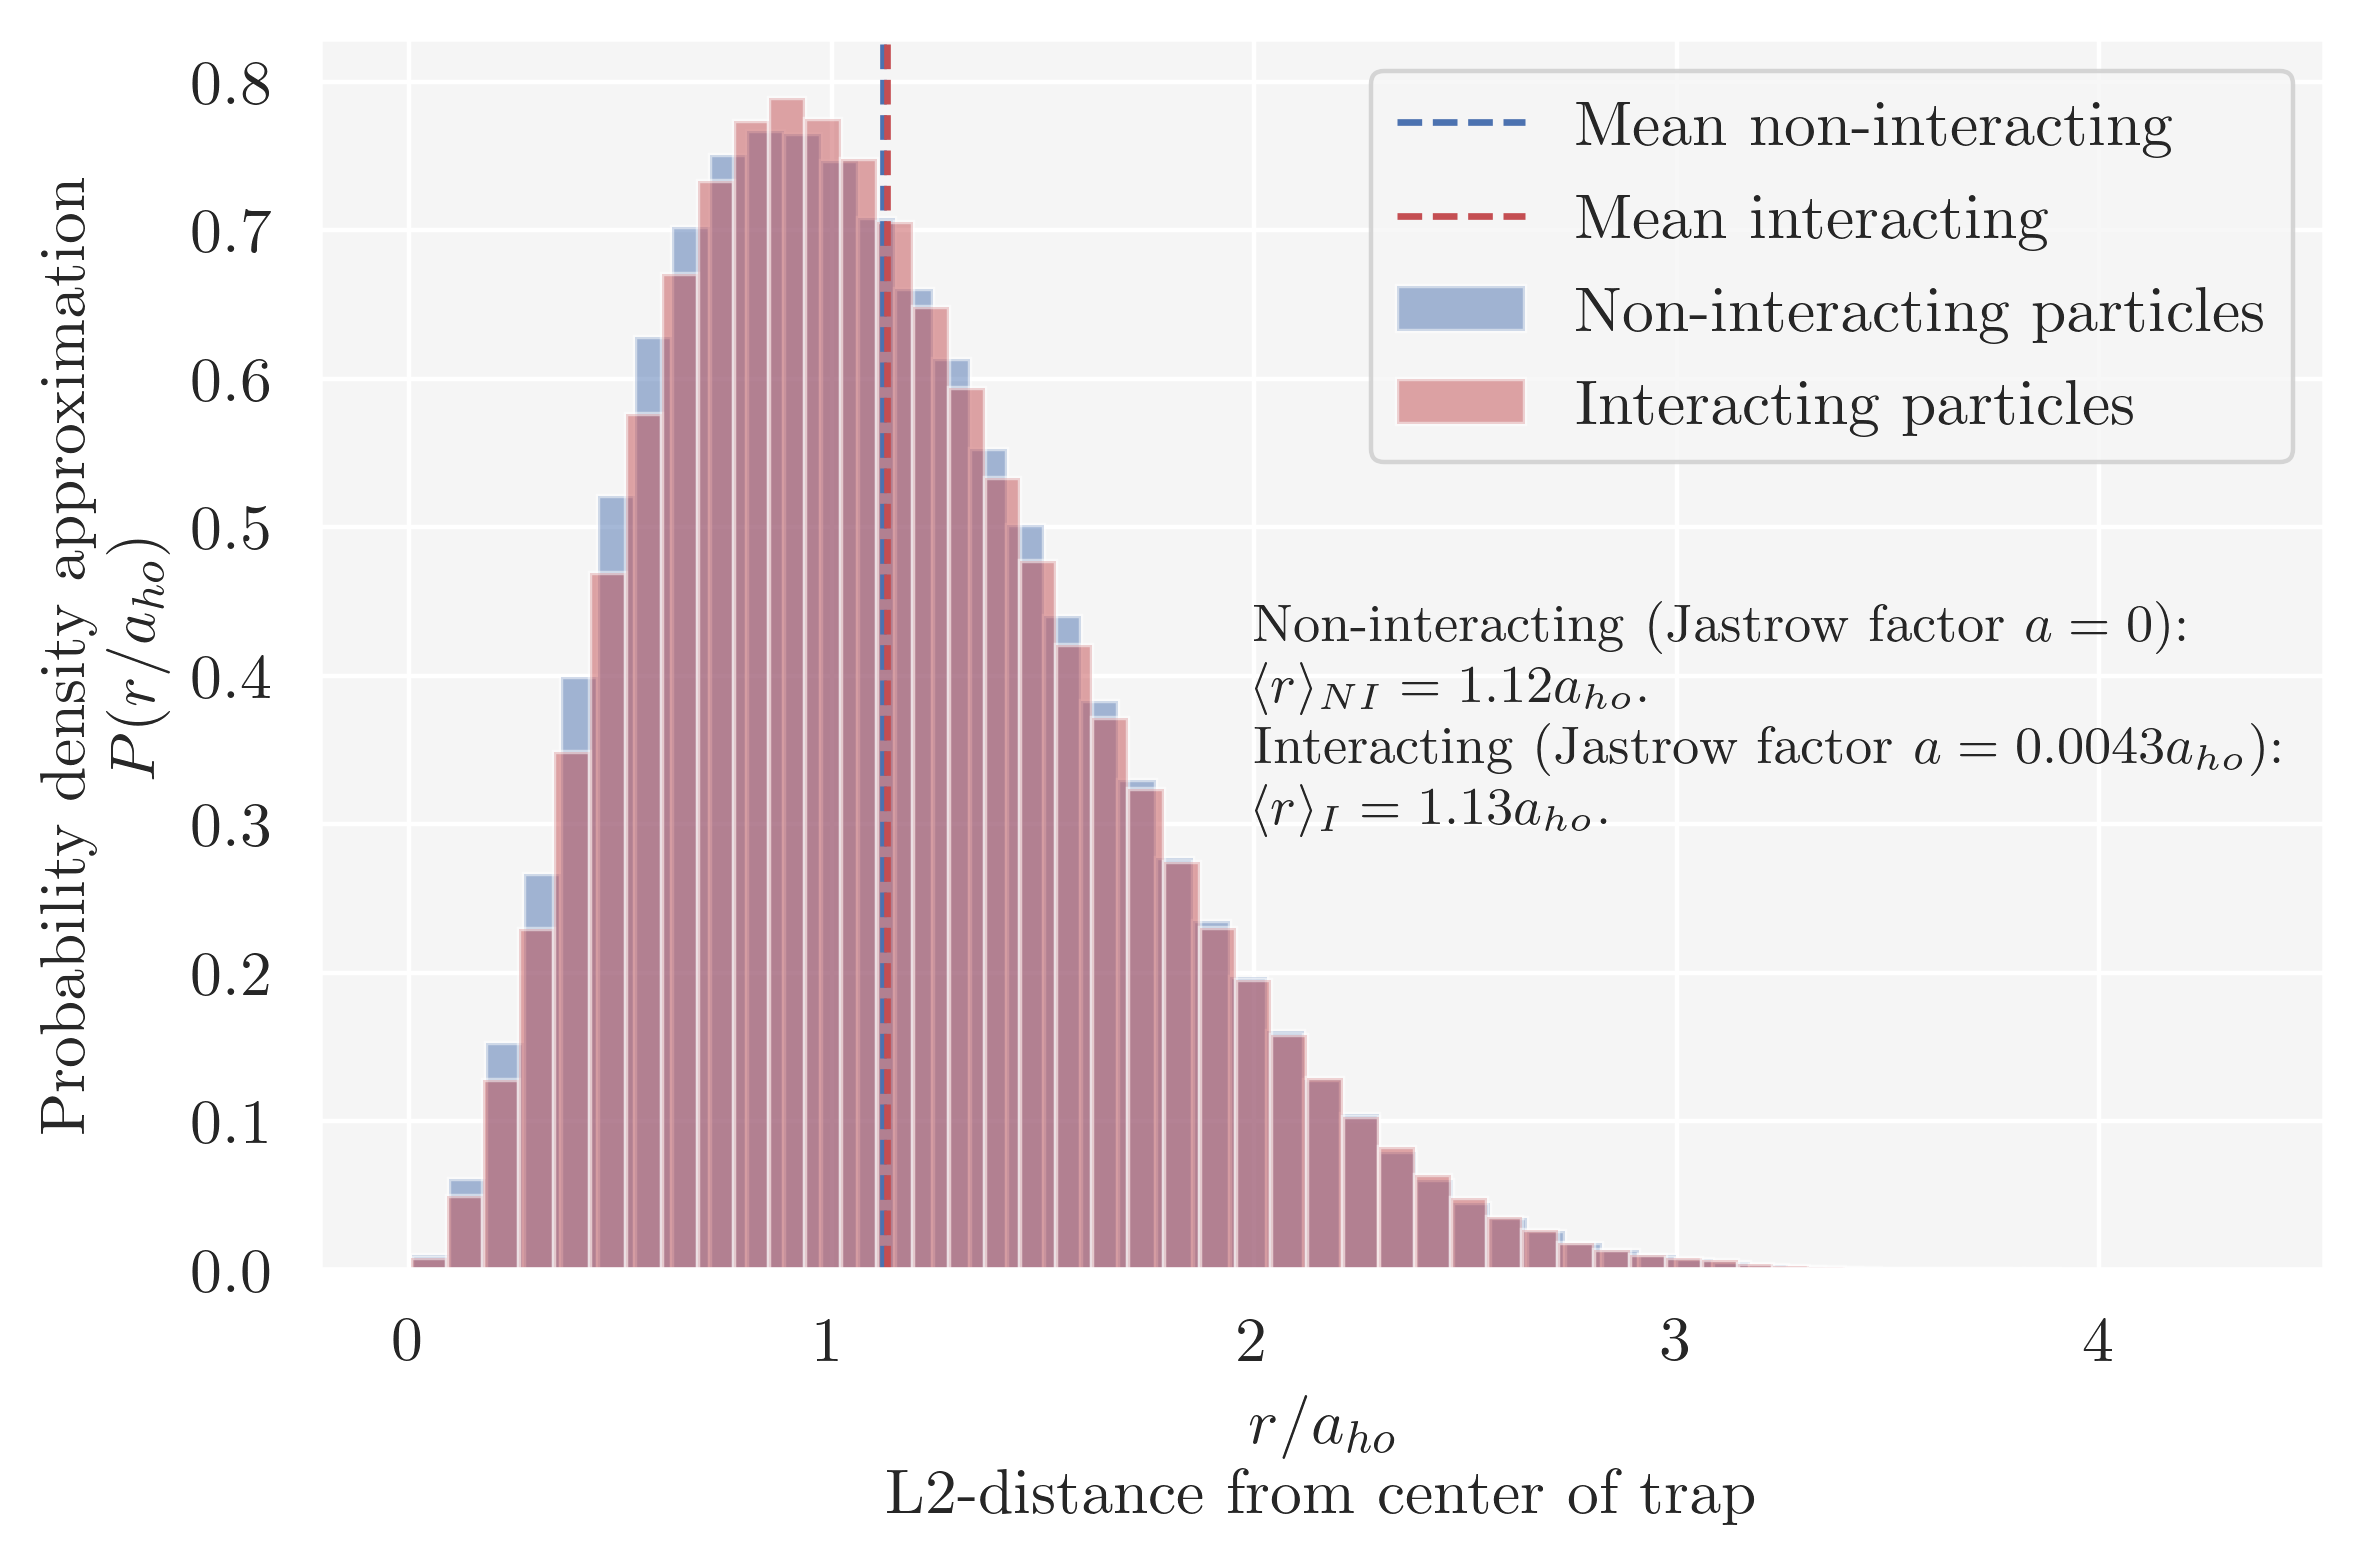

In [63]:
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True, dpi=200)
n, bins, patches = plt.hist(x=distances_NI_N50, bins=np.linspace(np.min(distances_NI_N50), np.max(distances_NI_N50), 50), density=True, color='b',
                            alpha=0.5, label="Non-interacting particles")
n, bins, patches = plt.hist(x=distances_I_N50, bins=np.linspace(np.min(distances_I_N50), np.max(distances_I_N50), 50), density=True, color='r',
                            alpha=0.5, label="Interacting particles")
plt.grid(True)
tex_xlabel = '\n'.join((r'$r/a_{ho}$',
                       'L2-distance from center of trap'))
tex_ylabel = '\n'.join(('Probability density approximation', 
                        r'$P(r/a_{ho})$'))
plt.xlabel(tex_xlabel)
plt.ylabel(tex_ylabel)
#plt.text(2.4, 0.45, r'$\langle r_N\rangle=%.2f a_{ho}$'%(np.mean(distances_NI_N50)))
#plt.text(2.4, 0.35, r'$\langle r_I\rangle=%.2f a_{ho}$'%(np.mean(distances_I_N50)))
ax.axvline(np.mean(distances_NI_N50), linestyle="--", color="b", label="Mean non-interacting")
ax.axvline(np.mean(distances_I_N50), linestyle="--", color="r", label="Mean interacting")
texstr = '\n'.join((r'Non-interacting (Jastrow factor $a=0$):',
                    r'$\quad\quad\quad\quad\langle r\rangle_{NI} = %.2fa_{ho}.$'%(np.mean(distances_NI_N50)),
                    r'Interacting (Jastrow factor $a=0.0043 a_{ho}$):',
                    r'$\quad\quad\quad\quad\langle r\rangle_{I} = %.2f a_{ho}.$'%(np.mean(distances_I_N50))))
plt.text(2, 0.3, texstr)
# Set a clean upper y-axis limit.
#plt.ylim(ymax=np.ceil(maxfreq / 10) + 1 if maxfreq % 10 else maxfreq + 1)
plt.legend()

fig.savefig(fig_path("OBD_50.pdf"), bbox_inches='tight')

## Comparison N=100

In [10]:
N = 100       # Number of particles
dim = 3      # Dimensionality
omega = 1.   # Oscillator frequency

# Exact energy 
exact_E = exact_energy(N, dim, omega)

# Instantiate wave function
wf = vmc.ASHONIB(N, dim, omega)

# Instantiate sampler
sampler_NI_N100 = vmc.samplers.Metropolis(wf)

# Config
nsamples = int(2**17)
initial_alpha = 0.5
initial_positions = safe_initial_positions_no_interactions(wf, initial_alpha, N, dim)
start = time.time()
results = sampler_NI_N100.sample(nsamples,
                         initial_positions,
                         initial_alpha,
                         scale=1.0,  # METROPOLIS
                         #dt=1e-10,     # METROPOLIS-HASTINGS
                         nchains=1,
                         warm=True,
                         warmup_iter=5000,
                         tune=True,
                         tune_iter=10000,
                         tune_interval=500,
                         tol_tune=1e-5,
                         optimize=False,
                         max_iter=70000,
                         batch_size=500,
                         gradient_method='adam',
                         eta=0.01,
                         tol_optim=1e-6,
                         )

end = time.time()
print("Sampler elapsed time:", end - start)
# Saving distances in flattened matrix
distances_NI_N100 = sampler_NI_N100.distance_samples.flatten()

wf = vmc.ASHOIB(N, dim, omega)
sampler_I_N100 = vmc.samplers.Metropolis(wf)
initial_positions, scale = interact_initial_positions(wf, initial_alpha, N, dim)
start = time.time()
results = sampler_I_N100.sample(nsamples,
                              initial_positions, 
                              initial_alpha, 
                              scale=1.0, 
                              nchains=1, 
                              warm=True, 
                              warmup_iter=10000, 
                              tune=True,
                              tune_iter=10000,
                              tune_interval=500,
                              tol_tune=100,
                              optimize=False,
                              )
end = time.time()
print("Sampler elapsed time:", end - start)
distances_I_N100 = sampler_I_N100.distance_samples.flatten()

Warm done
Tune done
Warm after tune done
Sampling energy
Sampler elapsed time: 25.97825598716736
Warm done
Tune done
Warm after tune done
Sampling energy
Sampler elapsed time: 696.9370608329773


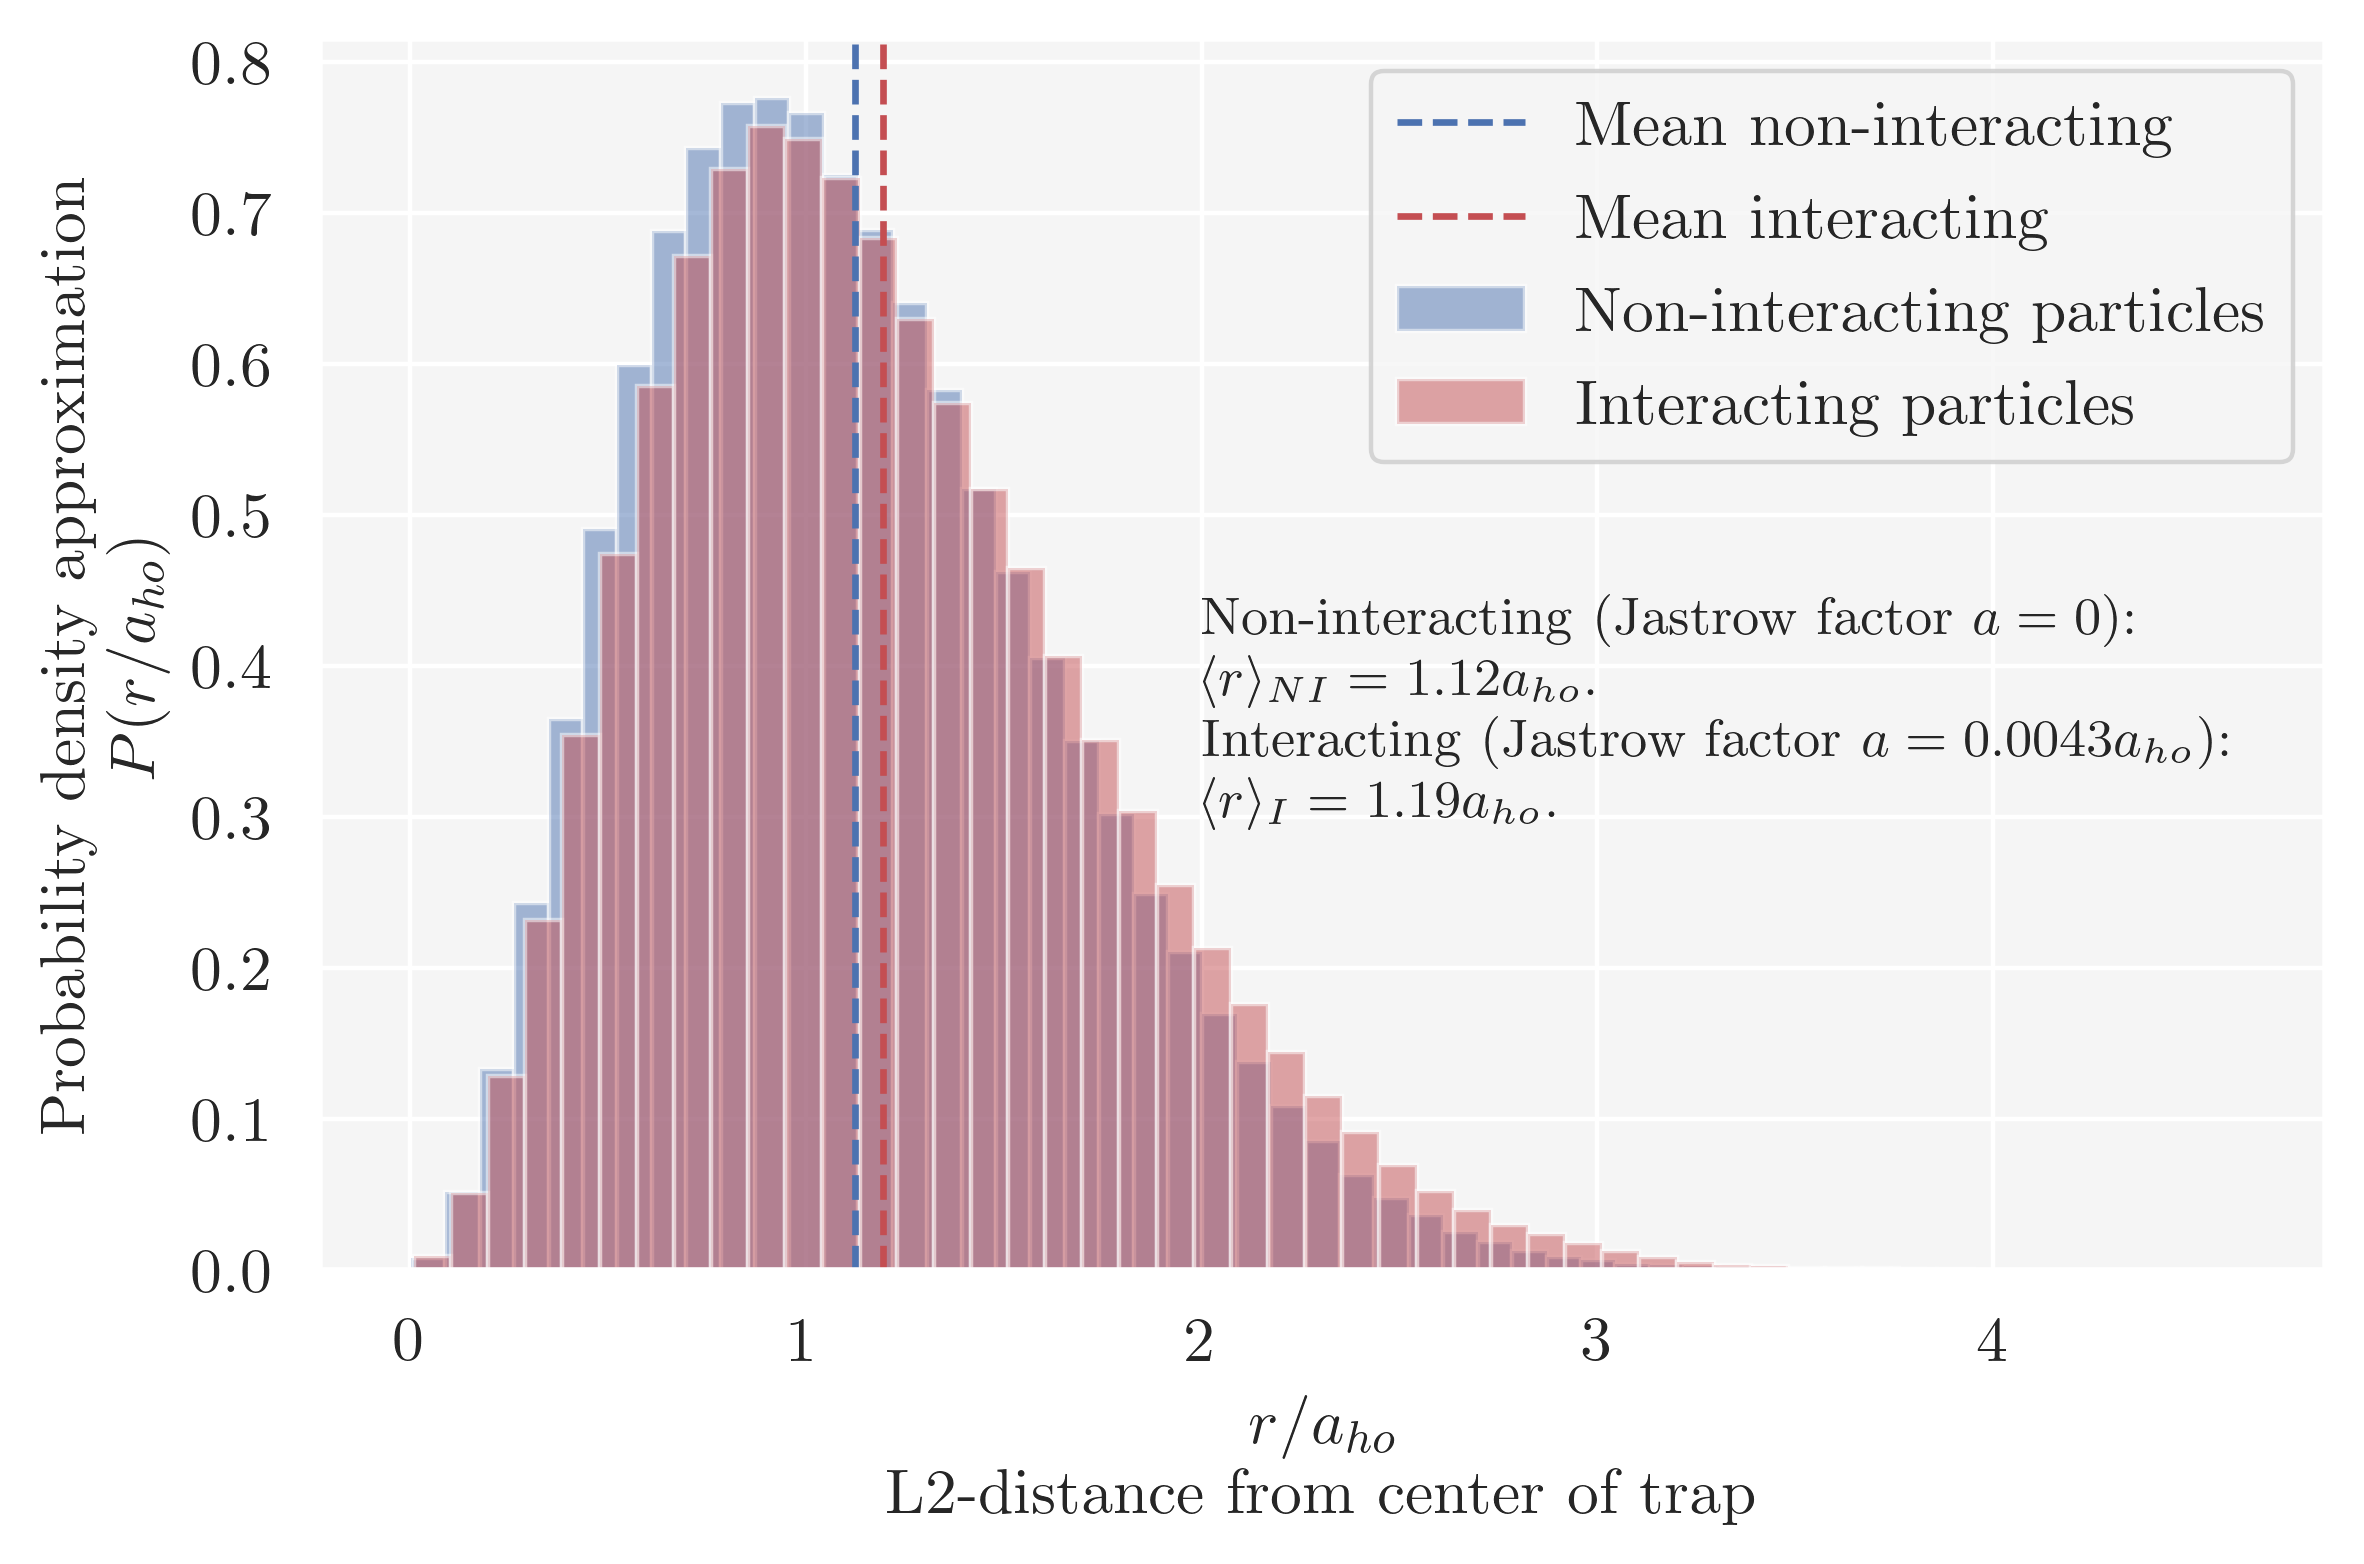

In [62]:
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True, dpi=200)
n, bins, patches = plt.hist(x=distances_NI_N100, bins=np.linspace(np.min(distances_NI_N100), np.max(distances_NI_N100), 50), density=True, color='b',
                            alpha=0.5, label="Non-interacting particles")
n, bins, patches = plt.hist(x=distances_I_N100, bins=np.linspace(np.min(distances_I_N100), np.max(distances_I_N100), 50), density=True, color='r',
                            alpha=0.5, label="Interacting particles")
plt.grid(True)
tex_xlabel = '\n'.join((r'$r/a_{ho}$',
                       'L2-distance from center of trap'))
tex_ylabel = '\n'.join(('Probability density approximation', 
                        r'$P(r/a_{ho})$'))
plt.xlabel(tex_xlabel)
plt.ylabel(tex_ylabel)
#plt.text(2.5, 0.45, r'$\langle r_N\rangle=%.2f a_{ho}$'%(np.mean(distances_NI_N100)))
#plt.text(2.5, 0.35, r'$\langle r_I\rangle=%.2f a_{ho}$'%(np.mean(distances_I_N100)))
ax.axvline(np.mean(distances_NI_N100), linestyle="--", color="b", label="Mean non-interacting")
ax.axvline(np.mean(distances_I_N100), linestyle="--", color="r", label="Mean interacting")
# Set a clean upper y-axis limit.
#plt.ylim(ymax=np.ceil(maxfreq / 10) + 1 if maxfreq % 10 else maxfreq + 1)
texstr = '\n'.join((r'Non-interacting (Jastrow factor $a=0$):',
                    r'$\quad\quad\quad\quad\langle r\rangle_{NI} = %.2fa_{ho}.$'%(np.mean(distances_NI_N100)),
                    r'Interacting (Jastrow factor $a=0.0043 a_{ho}$):',
                    r'$\quad\quad\quad\quad\langle r\rangle_{I} = %.2f a_{ho}.$'%(np.mean(distances_I_N100))))
plt.text(2, 0.3, texstr)
plt.legend()

fig.savefig(fig_path("OBD_100.pdf"), bbox_inches='tight')